<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#pip install yfinance
#!pip install finta
#!pip install --upgrade pandas
#!pip install --upgrade pandas-datareader

# 載入資料

In [21]:
import pandas as pd
import yfinance as yf
import seaborn as sns
y_symbols = ["^TWII"]
from datetime import datetime
startdate = datetime(2010,12,1)
enddate = datetime(2022,12,30)
df = yf.download(y_symbols, start=startdate, end=enddate)
print(df.shape)
display(df.head(3))
display(df.tail(3))

[*********************100%***********************]  1 of 1 completed
(2956, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-01,8430.599609,8520.110352,8428.639648,8520.110352,8520.078125,4202800
2010-12-02,8598.009766,8641.129883,8572.650391,8585.769531,8585.737305,4731800
2010-12-03,8630.879883,8659.620117,8618.259766,8624.009766,8623.977539,3710800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-27,14310.190430,14410.240234,14310.190430,14328.429688,14328.429688,1821100
2022-12-28,14249.830078,14249.830078,14119.299805,14173.099609,14173.099609,1958900
2022-12-29,14097.509766,14120.570312,13981.629883,14085.019531,14085.019531,1839200


# Label triple_barrier

https://sharegpt.com/c/qqTJZKo

In [22]:
import numpy as np
import math
def triple_barrier_signal(price,ub,lb,t):
  '''
  triple-barrier包含2個horizontal barrier，1個vertical barrier。
  首先解釋一下這3个barrier：
  根據3个barrier中第一個被touch的進行label
  barrier 1 (the upper barrier)首先達到，label 1
  barrier 2（the lower barrier)首先達到，label -1
  如果barrier 1和barrier 2都没有達到，则barrier 3達到，label 0
  '''
  signal = []
  for i in range(len(price)-t):
    # 情況1.如果price[i:i+t+1]這段序列有任何元素的值大於price[i]*ub則signal[i] = 1
    if max(price[i:i+t+1]) > price[i] * ub:
      signal.append(1)
    # 情況2.如果price[i:i+t+1]這段序列有任何元素的值低於price[i]*lb則signal[i] = -1
    elif min(price[i:i+t+1]) < price[i] * lb:
      signal.append(-1)
    # 如果以上情況1和情況2都沒有發生則signal[i] = 0
    else:
      signal.append(0)
  return signal

ret = triple_barrier_signal(df.Close.values.tolist(),1.03,0.97,20)
df = df.head(len(ret))
df['triple_barrier_signal'] = ret

<ipython-input-22-d719bd064884>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['triple_barrier_signal'] = ret


In [23]:
df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal
Date,,,,,,,
2022-11-04,12941.780273,13029.940430,12868.250000,13026.709961,13026.709961,2354400,1
2022-11-07,13109.349609,13246.589844,13103.349609,13223.730469,13223.730469,2750000,1
2022-11-08,13274.910156,13389.250000,13274.910156,13347.759766,13347.759766,3009500,1
2022-11-09,13410.190430,13638.809570,13410.190430,13638.809570,13638.809570,2981300,1
2022-11-10,13556.509766,13559.400391,13463.849609,13503.759766,13503.759766,2335900,1
2022-11-11,13878.950195,14045.509766,13878.950195,14007.559570,14007.559570,3988800,1
2022-11-14,14080.910156,14217.299805,14076.940430,14174.900391,14174.900391,3396800,1
2022-11-15,14325.490234,14568.509766,14278.530273,14546.309570,14546.309570,3441500,1
2022-11-16,14637.849609,14657.660156,14481.059570,14537.349609,14537.349609,3356100,1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='triple_barrier_signal', ylabel='count'>

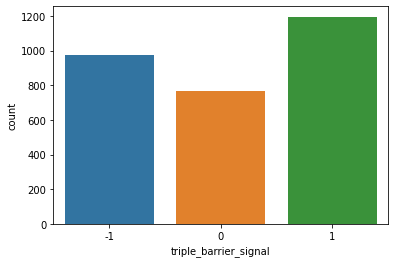

In [24]:
df['triple_barrier_signal'].value_counts()
sns.countplot(df['triple_barrier_signal'])

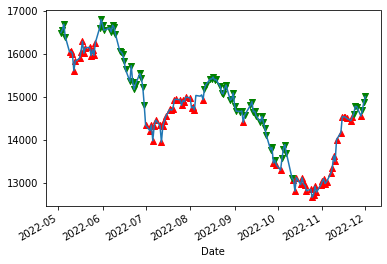

In [25]:
import matplotlib.pyplot as plt
df_recent = df.tail(150)
buy = df_recent[df_recent['triple_barrier_signal']==1]['Close']
sell = df_recent[df_recent['triple_barrier_signal']==-1]['Close']
df_recent['Close'].plot()
plt.scatter(buy.index,buy.values,color='red',marker='^')
plt.scatter(sell.index,sell.values,color='green',marker='v')
plt.show()

# 建立ohlcv

In [26]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

<ipython-input-27-4c3c4c479738>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = TA.RSI(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2935.000000
mean       53.136125
std        12.664317
min         9.948198
25%        44.252229
50%        53.969434
75%        61.886791
max       100.000000
Name: RSI, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197


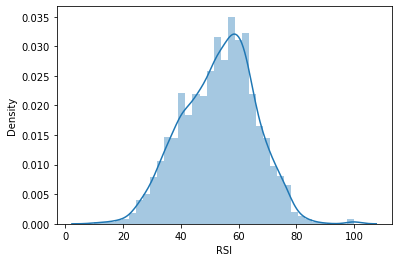

In [27]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

<ipython-input-28-7d686e802fee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Williams %R'] = TA.WILLIAMS(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2923.000000
mean      -41.453276
std        31.708750
min      -100.000000
25%       -69.906196
50%       -35.741387
75%       -12.369861
max        -0.000000
Name: Williams %R, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888


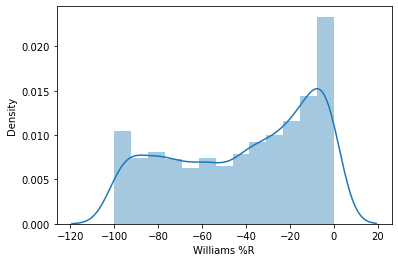

In [28]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

<ipython-input-29-f5fe9346dc29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = TA.SMA(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2896.000000
mean     10500.748280
std       2933.535635
min       7003.694133
25%       8429.804848
50%       9579.589606
75%      10911.407858
max      18134.302258
Name: SMA, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225


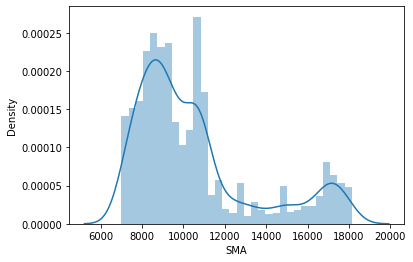

In [29]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

<ipython-input-30-fc487700578c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA'] = TA.EMA(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2936.000000
mean     10504.655905
std       2938.298037
min       6806.511665
25%       8467.397663
50%       9579.595960
75%      11016.391430
max      18370.191557
Name: EMA, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704


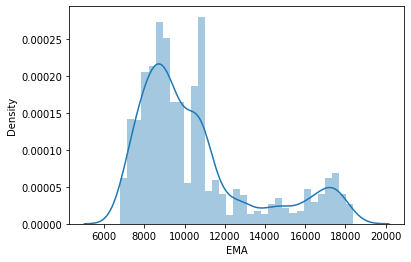

In [30]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

<ipython-input-31-47d0318f8f86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WMA'] = TA.WMA(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2928.000000
mean     10512.413986
std       2943.823469
min       6776.183974
25%       8459.387657
50%       9580.319477
75%      11035.434375
max      18389.146615
Name: WMA, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642


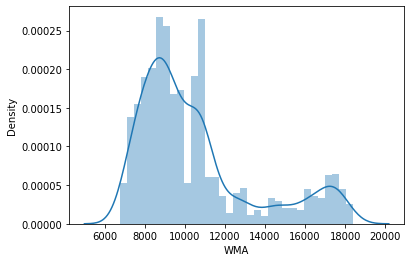

In [31]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

<ipython-input-32-a7e4d90d4bbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HMA'] = TA.HMA(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2918.000000
mean     10522.365063
std       2953.731133
min       6715.396428
25%       8447.202235
50%       9573.163947
75%      11096.802489
max      18487.953184
Name: HMA, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546


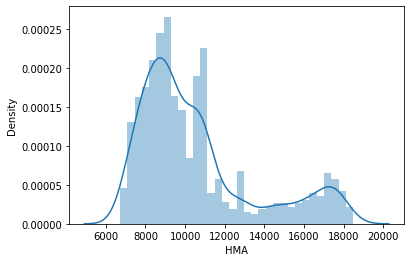

In [32]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

<ipython-input-33-2f860284cd53>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TEMA'] = TA.TEMA(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2936.000000
mean     10512.981164
std       2947.590137
min       6661.102660
25%       8459.325705
50%       9553.963750
75%      11081.493500
max      18516.770956
Name: TEMA, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244


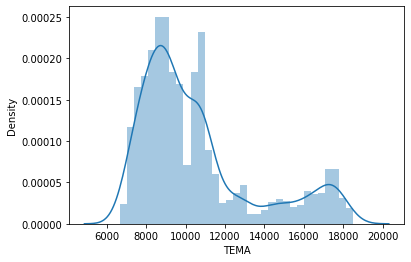

In [33]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

<ipython-input-34-f3a36296c205>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CCI'] = TA.CCI(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2935.000000
mean       17.779590
std       112.532283
min      -367.416775
25%       -67.213256
50%        39.125748
75%       101.832561
max       347.439300
Name: CCI, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664


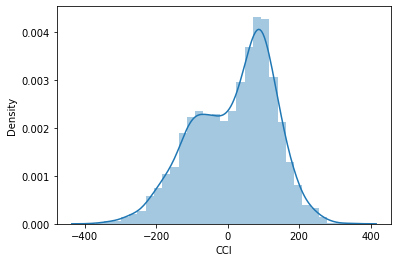

In [34]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

<ipython-input-35-636d59457fe4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CMO'] = TA.CMO(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2935.000000
mean        6.832126
std        29.754500
min       -86.464212
25%       -13.968337
50%         9.745036
75%        27.657234
max       100.000000
Name: CMO, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117


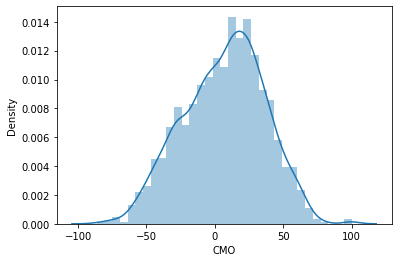

In [35]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

<ipython-input-36-a2be88ba92a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2936.000000
mean        0.434364
std        39.186492
min      -244.072759
25%       -19.389361
50%         0.588091
75%        20.630338
max       214.802204
Name: MACD, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537


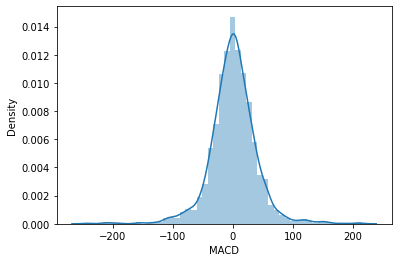

In [36]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

<ipython-input-37-a12562319965>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2936.000000
mean        0.003062
std         0.350371
min        -2.355901
25%        -0.201398
50%         0.002089
75%         0.203830
max         1.592874
Name: PPO, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579


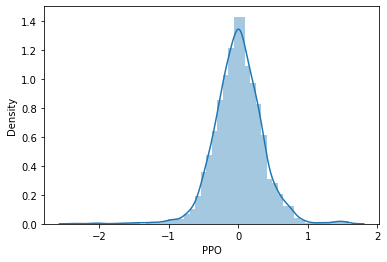

In [37]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

<ipython-input-38-d4d0f2e10498>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROC'] = TA.ROC(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2924.000000
mean        0.277789
std         3.526450
min       -23.361982
25%        -1.647353
50%         0.589706
75%         2.495040
max        16.773101
Name: ROC, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538,8.356303
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406,7.798645
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384,5.012151
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379,4.971107
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579,3.206932


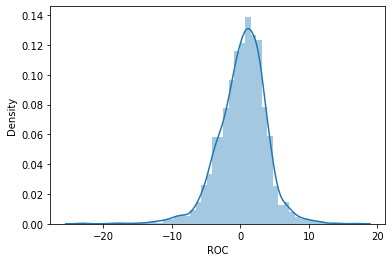

In [38]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

<ipython-input-39-f9a6fb514c9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CFI'] = TA.CFI(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2.927000e+03
mean     2.461007e+09
std      5.396535e+09
min     -6.487266e+09
25%     -3.889541e+08
50%      1.472681e+09
75%      3.428212e+09
max      2.656728e+10
Name: CFI, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538,8.356303,8.024368e+08
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406,7.798645,8.796457e+08
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384,5.012151,1.030117e+09
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379,4.971107,1.290941e+09
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579,3.206932,1.595721e+09


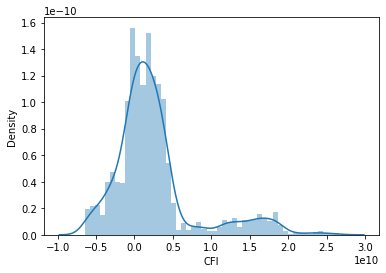

In [39]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

<ipython-input-40-5f9ae8d91f2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2923.000000
mean       -0.944204
std        17.454536
min      -102.667887
25%       -12.592355
50%         0.338669
75%        10.894941
max        46.931640
Name: DMI, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,...,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,...,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538,8.356303,8.024368e+08,30.475384
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,...,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406,7.798645,8.796457e+08,20.052097
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,...,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384,5.012151,1.030117e+09,21.195767
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,...,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379,4.971107,1.290941e+09,24.991144
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,...,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579,3.206932,1.595721e+09,32.948047


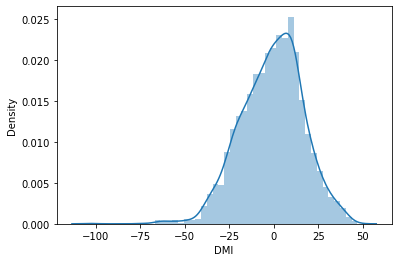

In [40]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

<ipython-input-41-04e925142cba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SAR'] = TA.SAR(ohlcv)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count     2936.000000
mean     10472.369774
std       2936.515091
min       6609.109863
25%       8444.911042
50%       9523.911602
75%      11088.615194
max      18619.609375
Name: SAR, dtype: float64


,Open,High,Low,Close,Adj Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,...,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-25,14764.940430,14835.660156,14756.009766,14778.509766,14778.509766,2808900,-1,73.338133,-3.661726,13522.949481,...,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538,8.356303,8.024368e+08,30.475384,14419.662121
2022-11-28,14636.900391,14638.190430,14503.120117,14556.870117,14556.870117,2567800,1,64.864913,-19.557766,13547.891197,...,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406,7.798645,8.796457e+08,20.052097,14502.861728
2022-11-29,14503.790039,14716.580078,14449.049805,14709.639648,14709.639648,3143000,-1,67.640144,-9.186437,13579.234113,...,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384,5.012151,1.030117e+09,21.195767,14835.660156
2022-11-30,14678.230469,14879.549805,14678.230469,14879.549805,14879.549805,4457700,-1,70.437023,-0.000000,13617.747999,...,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379,4.971107,1.290941e+09,24.991144,14449.049805
2022-12-01,15059.919922,15152.379883,14998.030273,15012.799805,15012.799805,3771700,-1,72.448197,-12.978888,13652.779225,...,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579,3.206932,1.595721e+09,32.948047,14449.049805


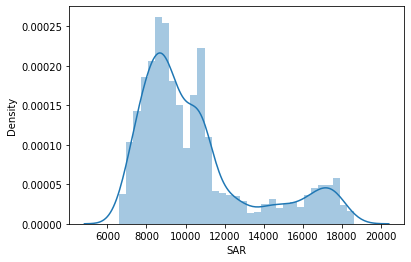

In [41]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [42]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(2936, 22)
(2896, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2022-11-25,73.338133,-3.661726,13522.949481,14494.837401,14628.559527,14837.322823,14835.809743,92.414573,59.271788,105.054827,0.735538,8.356303,8.024368e+08,30.475384,14419.662121,-1
2022-11-28,64.864913,-19.557766,13547.891197,14507.243944,14622.455339,14818.927946,14742.665447,64.023801,32.324869,74.240695,0.512406,7.798645,8.796457e+08,20.052097,14502.861728,1
2022-11-29,67.640144,-9.186437,13579.234113,14547.723085,14646.670378,14801.823190,14748.584778,65.071139,40.087904,58.210160,0.394384,5.012151,1.030117e+09,21.195767,14835.660156,-1
2022-11-30,70.437023,-0.000000,13617.747999,14614.088429,14701.038780,14808.694602,14828.550171,81.721878,47.526374,53.247245,0.354379,4.971107,1.290941e+09,24.991144,14449.049805,-1
2022-12-01,72.448197,-12.978888,13652.779225,14693.830704,14774.405642,14850.997546,14938.299244,107.523664,52.649117,53.020537,0.347579,3.206932,1.595721e+09,32.948047,14449.049805,-1


# 相關性分析

<AxesSubplot:>

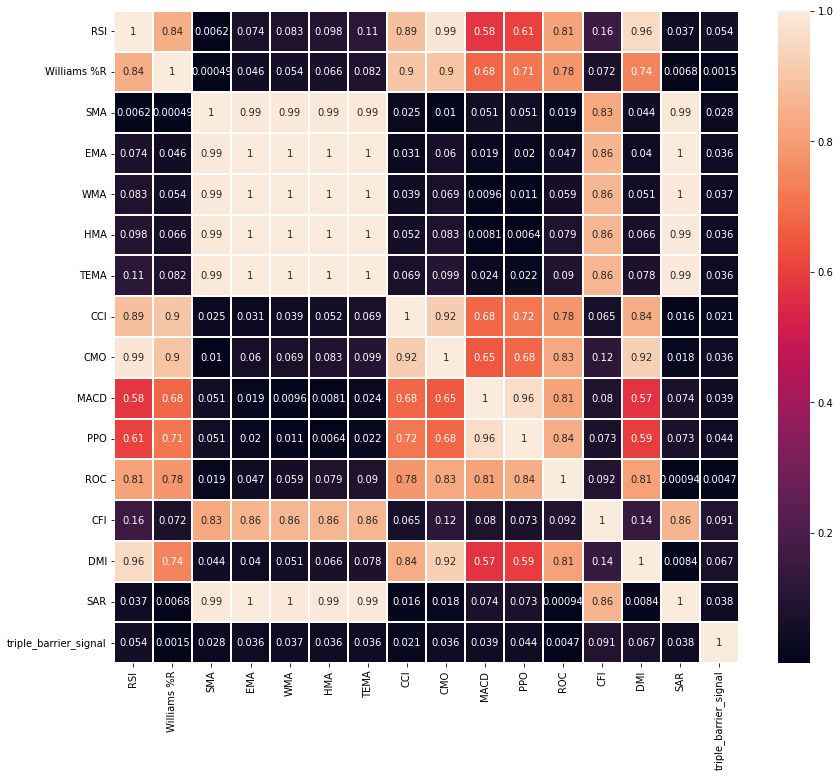

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [44]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,index = df.index,columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2022-11-25,0.853369,0.963383,0.585705,0.664868,0.676173,0.689903,0.689519,0.643250,0.883887,0.760834,0.782886,0.790288,0.220536,0.863317,0.650310,-1
2022-11-28,0.739301,0.804422,0.587946,0.665941,0.675648,0.688341,0.681662,0.603535,0.720455,0.693682,0.726379,0.776394,0.222871,0.776742,0.657238,1
2022-11-29,0.776662,0.908136,0.590762,0.669442,0.677733,0.686888,0.682162,0.605000,0.767537,0.658748,0.696491,0.706966,0.227424,0.786241,0.684947,-1
2022-11-30,0.814314,1.000000,0.594222,0.675181,0.682415,0.687472,0.688907,0.628292,0.812652,0.647933,0.686360,0.705943,0.235314,0.817765,0.652757,-1
2022-12-01,0.841389,0.870211,0.597369,0.682077,0.688732,0.691065,0.698164,0.664386,0.843721,0.647438,0.684638,0.661987,0.244535,0.883854,0.652757,-1


In [45]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [46]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
start_index = 0
end_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(start_index ,end_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 2882/2882 [00:07<00:00, 410.13it/s]

準備完成


# check

In [47]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 2882
第一筆的index開始和結束:2011-01-26-2011-02-23
最後一筆的index開始和結束:2022-11-11-2022-12-01


# Reshape X

(圖片數量,長,寬,1張)

In [48]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(2882, 15, 15)
(2882, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [49]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(2882, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]
(2882, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

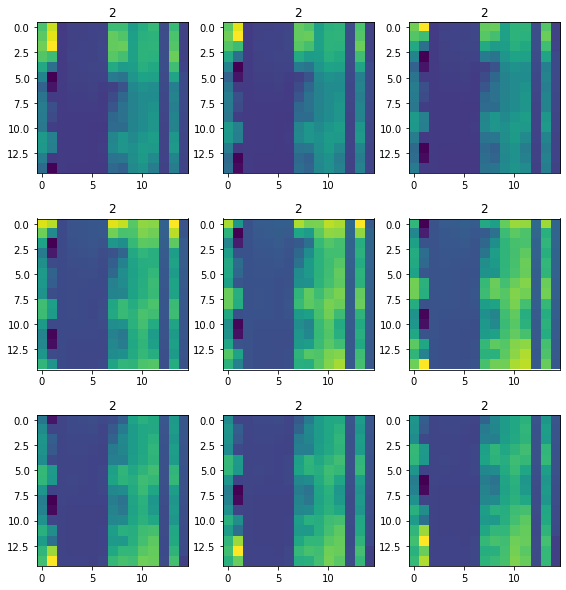

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and test sets

In [51]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(2842, 15, 15, 1) (2842, 3) (40, 15, 15, 1)


# 調整採樣

In [52]:
X_train2維 = X_train.reshape(X_train.shape[0],-1)
y_train數字 = np.array([ np.argmax(i) for i in y_train])
print(X_train2維.shape)
print(y_train數字.shape)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
X_train平衡 ,y_train平衡 = ros.fit_resample(X_train2維 ,y_train數字)
print(pd.DataFrame(y_train平衡)[0].value_counts().sort_index())#顯示結果

X_train = X_train平衡.reshape(X_train平衡.shape[0],15,15,1)#資料數,15,15,1
y_train = y_train平衡.reshape(y_train平衡.shape[0],1)#資料數,1
y_train = to_categorical(y_train , num_classes = 3)#one_hot
print(X_train.shape)
print(y_train.shape)

(2842, 225)
(2842,)
0    753
1    753
2    753
Name: 0, dtype: int64
(2259, 15, 15, 1)
(2259, 3)


# Split training and val sets

In [53]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(
    X_train,
    y_train, 
    test_size = 0.2,
    random_state = 42,
    shuffle = True,#是否洗牌
    stratify = y_train #是否根據y欄位做分層取樣
    )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(1807, 15, 15, 1) (1807, 3) (452, 15, 15, 1) (452, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [54]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

1    1181
2     948
0     753
dtype: int64

In [55]:
pd.Series([np.argmax(i) for i in y_train]).value_counts()

0    753
1    753
2    753
dtype: int64

In [56]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    603
0    602
1    602
dtype: int64

In [57]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

0    151
1    151
2    150
dtype: int64

# CNN

In [58]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [59]:
nclasses = 3 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))#15,15,32
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))#15,15,64
model.add(MaxPool2D(pool_size=(5,5)))# 3,3,64
model.add(Flatten())#576
model.add(Dropout(0.5))#288
model.add(Dense(128, activation='relu'))#128
model.add(Dropout(0.5))#64
model.add(Dense(32, activation='relu'))#32
model.add(Dropout(0.5))#16
model.add(Dense(nclasses, activation='softmax'))#3
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                        

In [60]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [61]:
#1
lr_reduction = ReduceLROnPlateau(
    monitor = 'val_acc', 
    factor=0.5, 
    patience = 3, 
    verbose = 1, 
    min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=50,  
                   mode='max',
                   restore_best_weights=True)#恢復最佳權重

# fit

In [62]:
history = model.fit(
    xtrain,
    ytrain,
    batch_size = 128,
    epochs = 500,
    validation_data=(xval,yval),
    verbose=1,callbacks=[es]
    )

Epoch 1/500
15/15 [==============================] - ETA: 0s - loss: 1.1055 - accuracy: 0.3287

15/15 [==============================] - 13s 37ms/step - loss: 1.1055 - accuracy: 0.3287 - val_loss: 1.0993 - val_accuracy: 0.3341
Epoch 2/500
10/15 [===================>..........] - ETA: 0s - loss: 1.1016 - accuracy: 0.3367

15/15 [==============================] - 0s 8ms/step - loss: 1.1027 - accuracy: 0.3337 - val_loss: 1.0981 - val_accuracy: 0.3341
Epoch 3/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0983 - accuracy: 0.3466

15/15 [==============================] - 0s 8ms/step - loss: 1.0979 - accuracy: 0.3448 - val_loss: 1.0947 - val_accuracy: 0.3739
Epoch 4/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0960 - accuracy: 0.3617

15/15 [==============================] - 0s 9ms/step - loss: 1.0955 - accuracy: 0.3553 - val_loss: 1.0905 - val_accuracy: 0.4071
Epoch 5/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0910 - accuracy: 0.3679

15/15 [==============================] - 0s 8ms/step - loss: 1.0918 - accuracy: 0.3669 - val_loss: 1.0861 - val_accuracy: 0.3850
Epoch 6/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0883 - accuracy: 0.3707

15/15 [==============================] - 0s 8ms/step - loss: 1.0883 - accuracy: 0.3697 - val_loss: 1.0796 - val_accuracy: 0.3872
Epoch 7/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0802 - accuracy: 0.3892

15/15 [==============================] - 0s 8ms/step - loss: 1.0807 - accuracy: 0.3901 - val_loss: 1.0723 - val_accuracy: 0.3739
Epoch 8/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0741 - accuracy: 0.3700

15/15 [==============================] - 0s 8ms/step - loss: 1.0783 - accuracy: 0.3702 - val_loss: 1.0650 - val_accuracy: 0.3827
Epoch 9/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0659 - accuracy: 0.4233

15/15 [==============================] - 0s 8ms/step - loss: 1.0640 - accuracy: 0.4234 - val_loss: 1.0525 - val_accuracy: 0.4270
Epoch 10/500
15/15 [==============================] - ETA: 0s - loss: 1.0676 - accuracy: 0.4068

15/15 [==============================] - 0s 11ms/step - loss: 1.0676 - accuracy: 0.4068 - val_loss: 1.0570 - val_accuracy: 0.4535
Epoch 11/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0645 - accuracy: 0.4240

15/15 [==============================] - 0s 8ms/step - loss: 1.0626 - accuracy: 0.4217 - val_loss: 1.0392 - val_accuracy: 0.5066
Epoch 12/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0426 - accuracy: 0.4339

15/15 [==============================] - 0s 9ms/step - loss: 1.0526 - accuracy: 0.4245 - val_loss: 1.0237 - val_accuracy: 0.5088
Epoch 13/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0623 - accuracy: 0.4411

15/15 [==============================] - 0s 9ms/step - loss: 1.0589 - accuracy: 0.4366 - val_loss: 1.0340 - val_accuracy: 0.4978
Epoch 14/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0372 - accuracy: 0.4638

15/15 [==============================] - 0s 11ms/step - loss: 1.0392 - accuracy: 0.4621 - val_loss: 1.0093 - val_accuracy: 0.5111
Epoch 15/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0355 - accuracy: 0.4625

15/15 [==============================] - 0s 8ms/step - loss: 1.0321 - accuracy: 0.4649 - val_loss: 1.0093 - val_accuracy: 0.5177
Epoch 16/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0400 - accuracy: 0.4524

15/15 [==============================] - 0s 9ms/step - loss: 1.0385 - accuracy: 0.4549 - val_loss: 1.0038 - val_accuracy: 0.5155
Epoch 17/500
 9/15 [=================>............] - ETA: 0s - loss: 1.0310 - accuracy: 0.4540

15/15 [==============================] - 0s 9ms/step - loss: 1.0260 - accuracy: 0.4588 - val_loss: 0.9993 - val_accuracy: 0.5000
Epoch 18/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0318 - accuracy: 0.4680

15/15 [==============================] - 0s 8ms/step - loss: 1.0293 - accuracy: 0.4726 - val_loss: 1.0093 - val_accuracy: 0.4823
Epoch 19/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0199 - accuracy: 0.4727

15/15 [==============================] - 0s 9ms/step - loss: 1.0188 - accuracy: 0.4693 - val_loss: 0.9898 - val_accuracy: 0.4912
Epoch 20/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0307 - accuracy: 0.4594

15/15 [==============================] - 0s 9ms/step - loss: 1.0265 - accuracy: 0.4693 - val_loss: 0.9904 - val_accuracy: 0.4823
Epoch 21/500
11/15 [=====================>........] - ETA: 0s - loss: 1.0297 - accuracy: 0.4794

15/15 [==============================] - 0s 9ms/step - loss: 1.0277 - accuracy: 0.4765 - val_loss: 0.9930 - val_accuracy: 0.5066
Epoch 22/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0248 - accuracy: 0.4711

15/15 [==============================] - 0s 9ms/step - loss: 1.0188 - accuracy: 0.4748 - val_loss: 0.9906 - val_accuracy: 0.4912
Epoch 23/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0218 - accuracy: 0.4797

15/15 [==============================] - 0s 9ms/step - loss: 1.0180 - accuracy: 0.4776 - val_loss: 0.9842 - val_accuracy: 0.4956
Epoch 24/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0226 - accuracy: 0.4688

15/15 [==============================] - 0s 9ms/step - loss: 1.0184 - accuracy: 0.4820 - val_loss: 0.9854 - val_accuracy: 0.5111
Epoch 25/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0034 - accuracy: 0.4773

15/15 [==============================] - 0s 9ms/step - loss: 1.0049 - accuracy: 0.4792 - val_loss: 0.9838 - val_accuracy: 0.5177
Epoch 26/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0100 - accuracy: 0.4867

15/15 [==============================] - 0s 9ms/step - loss: 1.0092 - accuracy: 0.4931 - val_loss: 0.9845 - val_accuracy: 0.4978
Epoch 27/500
11/15 [=====================>........] - ETA: 0s - loss: 0.9988 - accuracy: 0.4886

15/15 [==============================] - 0s 8ms/step - loss: 1.0062 - accuracy: 0.4920 - val_loss: 0.9863 - val_accuracy: 0.4978
Epoch 28/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0108 - accuracy: 0.4789

15/15 [==============================] - 0s 9ms/step - loss: 1.0047 - accuracy: 0.4958 - val_loss: 0.9761 - val_accuracy: 0.5088
Epoch 29/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9987 - accuracy: 0.4991

15/15 [==============================] - 0s 9ms/step - loss: 1.0022 - accuracy: 0.4859 - val_loss: 0.9745 - val_accuracy: 0.5111
Epoch 30/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9809 - accuracy: 0.5107

15/15 [==============================] - 0s 9ms/step - loss: 0.9989 - accuracy: 0.4975 - val_loss: 0.9718 - val_accuracy: 0.5199
Epoch 31/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0059 - accuracy: 0.4922

15/15 [==============================] - 0s 9ms/step - loss: 1.0053 - accuracy: 0.4892 - val_loss: 0.9837 - val_accuracy: 0.5155
Epoch 32/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9973 - accuracy: 0.5141

15/15 [==============================] - 0s 9ms/step - loss: 1.0062 - accuracy: 0.5036 - val_loss: 0.9814 - val_accuracy: 0.5354
Epoch 33/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9932 - accuracy: 0.4859

15/15 [==============================] - 0s 8ms/step - loss: 0.9983 - accuracy: 0.4848 - val_loss: 0.9715 - val_accuracy: 0.5133
Epoch 34/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9872 - accuracy: 0.5125

15/15 [==============================] - 0s 8ms/step - loss: 0.9898 - accuracy: 0.5080 - val_loss: 0.9683 - val_accuracy: 0.5066
Epoch 35/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9965 - accuracy: 0.5020

15/15 [==============================] - 0s 10ms/step - loss: 0.9959 - accuracy: 0.4925 - val_loss: 0.9690 - val_accuracy: 0.5088
Epoch 36/500
10/15 [===================>..........] - ETA: 0s - loss: 1.0014 - accuracy: 0.5008

15/15 [==============================] - 0s 9ms/step - loss: 0.9915 - accuracy: 0.5163 - val_loss: 0.9681 - val_accuracy: 0.5066
Epoch 37/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9863 - accuracy: 0.4953

15/15 [==============================] - 0s 8ms/step - loss: 0.9763 - accuracy: 0.5047 - val_loss: 0.9649 - val_accuracy: 0.4978
Epoch 38/500
 8/15 [===============>..............] - ETA: 0s - loss: 1.0035 - accuracy: 0.5039

15/15 [==============================] - 0s 9ms/step - loss: 0.9950 - accuracy: 0.5025 - val_loss: 0.9625 - val_accuracy: 0.5288
Epoch 39/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9888 - accuracy: 0.4984

15/15 [==============================] - 0s 9ms/step - loss: 0.9848 - accuracy: 0.4942 - val_loss: 0.9606 - val_accuracy: 0.4956
Epoch 40/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9859 - accuracy: 0.4922

15/15 [==============================] - 0s 9ms/step - loss: 0.9814 - accuracy: 0.4970 - val_loss: 0.9621 - val_accuracy: 0.5199
Epoch 41/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9907 - accuracy: 0.5156

15/15 [==============================] - 0s 8ms/step - loss: 0.9840 - accuracy: 0.5174 - val_loss: 0.9627 - val_accuracy: 0.5288
Epoch 42/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9794 - accuracy: 0.5109

15/15 [==============================] - 0s 8ms/step - loss: 0.9819 - accuracy: 0.5136 - val_loss: 0.9695 - val_accuracy: 0.5420
Epoch 43/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9784 - accuracy: 0.5000

15/15 [==============================] - 0s 9ms/step - loss: 0.9835 - accuracy: 0.5008 - val_loss: 0.9616 - val_accuracy: 0.5288
Epoch 44/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9769 - accuracy: 0.5125

15/15 [==============================] - 0s 9ms/step - loss: 0.9764 - accuracy: 0.5025 - val_loss: 0.9582 - val_accuracy: 0.5155
Epoch 45/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9861 - accuracy: 0.5289

15/15 [==============================] - 0s 8ms/step - loss: 0.9812 - accuracy: 0.5230 - val_loss: 0.9556 - val_accuracy: 0.5243
Epoch 46/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9736 - accuracy: 0.5102

15/15 [==============================] - 0s 9ms/step - loss: 0.9724 - accuracy: 0.5130 - val_loss: 0.9558 - val_accuracy: 0.5133
Epoch 47/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9780 - accuracy: 0.5172

15/15 [==============================] - 0s 9ms/step - loss: 0.9750 - accuracy: 0.5202 - val_loss: 0.9614 - val_accuracy: 0.5265
Epoch 48/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9732 - accuracy: 0.5113

15/15 [==============================] - 0s 9ms/step - loss: 0.9737 - accuracy: 0.5086 - val_loss: 0.9551 - val_accuracy: 0.5553
Epoch 49/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9851 - accuracy: 0.5094

15/15 [==============================] - 0s 9ms/step - loss: 0.9788 - accuracy: 0.5042 - val_loss: 0.9509 - val_accuracy: 0.5310
Epoch 50/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9895 - accuracy: 0.5109

15/15 [==============================] - 0s 8ms/step - loss: 0.9710 - accuracy: 0.5302 - val_loss: 0.9498 - val_accuracy: 0.5376
Epoch 51/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9624 - accuracy: 0.5164

15/15 [==============================] - 0s 9ms/step - loss: 0.9679 - accuracy: 0.5136 - val_loss: 0.9491 - val_accuracy: 0.5509
Epoch 52/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9583 - accuracy: 0.5437

15/15 [==============================] - 0s 9ms/step - loss: 0.9675 - accuracy: 0.5318 - val_loss: 0.9492 - val_accuracy: 0.5487
Epoch 53/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9632 - accuracy: 0.5188

15/15 [==============================] - 0s 9ms/step - loss: 0.9656 - accuracy: 0.5141 - val_loss: 0.9510 - val_accuracy: 0.5465
Epoch 54/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9609 - accuracy: 0.5063

15/15 [==============================] - 0s 9ms/step - loss: 0.9660 - accuracy: 0.5091 - val_loss: 0.9485 - val_accuracy: 0.5465
Epoch 55/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9512 - accuracy: 0.5258

15/15 [==============================] - 0s 8ms/step - loss: 0.9488 - accuracy: 0.5318 - val_loss: 0.9474 - val_accuracy: 0.5288
Epoch 56/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9551 - accuracy: 0.5281

15/15 [==============================] - 0s 8ms/step - loss: 0.9554 - accuracy: 0.5263 - val_loss: 0.9557 - val_accuracy: 0.5265
Epoch 57/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9526 - accuracy: 0.5344

15/15 [==============================] - 0s 8ms/step - loss: 0.9601 - accuracy: 0.5257 - val_loss: 0.9543 - val_accuracy: 0.5420
Epoch 58/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9538 - accuracy: 0.5278

15/15 [==============================] - 0s 9ms/step - loss: 0.9484 - accuracy: 0.5434 - val_loss: 0.9443 - val_accuracy: 0.5531
Epoch 59/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9613 - accuracy: 0.4984

15/15 [==============================] - 0s 8ms/step - loss: 0.9583 - accuracy: 0.5102 - val_loss: 0.9455 - val_accuracy: 0.5597
Epoch 60/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9479 - accuracy: 0.5406

15/15 [==============================] - 0s 10ms/step - loss: 0.9512 - accuracy: 0.5340 - val_loss: 0.9487 - val_accuracy: 0.5509
Epoch 61/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9479 - accuracy: 0.5165

15/15 [==============================] - 0s 10ms/step - loss: 0.9540 - accuracy: 0.5180 - val_loss: 0.9628 - val_accuracy: 0.5310
Epoch 62/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9580 - accuracy: 0.5336

15/15 [==============================] - 0s 8ms/step - loss: 0.9617 - accuracy: 0.5335 - val_loss: 0.9413 - val_accuracy: 0.5553
Epoch 63/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9571 - accuracy: 0.5312

15/15 [==============================] - 0s 9ms/step - loss: 0.9559 - accuracy: 0.5246 - val_loss: 0.9373 - val_accuracy: 0.5442
Epoch 64/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9376 - accuracy: 0.5227

15/15 [==============================] - 0s 9ms/step - loss: 0.9451 - accuracy: 0.5136 - val_loss: 0.9499 - val_accuracy: 0.5487
Epoch 65/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9660 - accuracy: 0.5219

15/15 [==============================] - 0s 9ms/step - loss: 0.9529 - accuracy: 0.5324 - val_loss: 0.9398 - val_accuracy: 0.5575
Epoch 66/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9373 - accuracy: 0.5305

15/15 [==============================] - 0s 9ms/step - loss: 0.9514 - accuracy: 0.5191 - val_loss: 0.9358 - val_accuracy: 0.5708
Epoch 67/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9481 - accuracy: 0.5367

15/15 [==============================] - 0s 8ms/step - loss: 0.9480 - accuracy: 0.5329 - val_loss: 0.9407 - val_accuracy: 0.5575
Epoch 68/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9381 - accuracy: 0.5381

15/15 [==============================] - 0s 10ms/step - loss: 0.9392 - accuracy: 0.5396 - val_loss: 0.9333 - val_accuracy: 0.5487
Epoch 69/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9507 - accuracy: 0.5336

15/15 [==============================] - 0s 9ms/step - loss: 0.9355 - accuracy: 0.5490 - val_loss: 0.9466 - val_accuracy: 0.5442
Epoch 70/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9303 - accuracy: 0.5375

15/15 [==============================] - 0s 8ms/step - loss: 0.9345 - accuracy: 0.5318 - val_loss: 0.9327 - val_accuracy: 0.5509
Epoch 71/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9375 - accuracy: 0.5406

15/15 [==============================] - 0s 11ms/step - loss: 0.9511 - accuracy: 0.5208 - val_loss: 0.9339 - val_accuracy: 0.5442
Epoch 72/500
15/15 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.5434

15/15 [==============================] - 0s 15ms/step - loss: 0.9380 - accuracy: 0.5434 - val_loss: 0.9342 - val_accuracy: 0.5642
Epoch 73/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9367 - accuracy: 0.5332

15/15 [==============================] - 0s 11ms/step - loss: 0.9395 - accuracy: 0.5346 - val_loss: 0.9343 - val_accuracy: 0.5708
Epoch 74/500
15/15 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.5335

15/15 [==============================] - 0s 15ms/step - loss: 0.9366 - accuracy: 0.5335 - val_loss: 0.9336 - val_accuracy: 0.5575
Epoch 75/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9392 - accuracy: 0.5410

15/15 [==============================] - 0s 11ms/step - loss: 0.9533 - accuracy: 0.5379 - val_loss: 0.9392 - val_accuracy: 0.5619
Epoch 76/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9562 - accuracy: 0.5122

15/15 [==============================] - 0s 10ms/step - loss: 0.9544 - accuracy: 0.5174 - val_loss: 0.9461 - val_accuracy: 0.5465
Epoch 77/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9501 - accuracy: 0.5479

15/15 [==============================] - 0s 11ms/step - loss: 0.9481 - accuracy: 0.5462 - val_loss: 0.9368 - val_accuracy: 0.5442
Epoch 78/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9256 - accuracy: 0.5365

15/15 [==============================] - 0s 10ms/step - loss: 0.9285 - accuracy: 0.5324 - val_loss: 0.9287 - val_accuracy: 0.5442
Epoch 79/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9351 - accuracy: 0.5460

15/15 [==============================] - 0s 10ms/step - loss: 0.9371 - accuracy: 0.5418 - val_loss: 0.9259 - val_accuracy: 0.5509
Epoch 80/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9280 - accuracy: 0.5356

15/15 [==============================] - 0s 11ms/step - loss: 0.9249 - accuracy: 0.5396 - val_loss: 0.9238 - val_accuracy: 0.5730
Epoch 81/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9421 - accuracy: 0.5365

15/15 [==============================] - 0s 11ms/step - loss: 0.9239 - accuracy: 0.5589 - val_loss: 0.9353 - val_accuracy: 0.5531
Epoch 82/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9346 - accuracy: 0.5400

15/15 [==============================] - 0s 11ms/step - loss: 0.9312 - accuracy: 0.5495 - val_loss: 0.9268 - val_accuracy: 0.5686
Epoch 83/500
15/15 [==============================] - ETA: 0s - loss: 0.9311 - accuracy: 0.5445

15/15 [==============================] - 0s 12ms/step - loss: 0.9311 - accuracy: 0.5445 - val_loss: 0.9256 - val_accuracy: 0.5487
Epoch 84/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9106 - accuracy: 0.5460

15/15 [==============================] - 0s 11ms/step - loss: 0.9121 - accuracy: 0.5479 - val_loss: 0.9255 - val_accuracy: 0.5553
Epoch 85/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9290 - accuracy: 0.5391

15/15 [==============================] - 0s 10ms/step - loss: 0.9331 - accuracy: 0.5407 - val_loss: 0.9222 - val_accuracy: 0.5642
Epoch 86/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9207 - accuracy: 0.5547

15/15 [==============================] - 0s 9ms/step - loss: 0.9255 - accuracy: 0.5534 - val_loss: 0.9177 - val_accuracy: 0.5686
Epoch 87/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9110 - accuracy: 0.5523

15/15 [==============================] - 0s 9ms/step - loss: 0.9149 - accuracy: 0.5551 - val_loss: 0.9153 - val_accuracy: 0.5774
Epoch 88/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9199 - accuracy: 0.5367

15/15 [==============================] - 0s 8ms/step - loss: 0.9130 - accuracy: 0.5501 - val_loss: 0.9207 - val_accuracy: 0.5597
Epoch 89/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9133 - accuracy: 0.5664

15/15 [==============================] - 0s 9ms/step - loss: 0.9152 - accuracy: 0.5612 - val_loss: 0.9211 - val_accuracy: 0.5575
Epoch 90/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9054 - accuracy: 0.5547

15/15 [==============================] - 0s 9ms/step - loss: 0.9070 - accuracy: 0.5600 - val_loss: 0.9237 - val_accuracy: 0.5664
Epoch 91/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9078 - accuracy: 0.5586

15/15 [==============================] - 0s 9ms/step - loss: 0.9059 - accuracy: 0.5540 - val_loss: 0.9137 - val_accuracy: 0.5752
Epoch 92/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8986 - accuracy: 0.5523

15/15 [==============================] - 0s 9ms/step - loss: 0.8936 - accuracy: 0.5562 - val_loss: 0.9127 - val_accuracy: 0.5752
Epoch 93/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9162 - accuracy: 0.5633

15/15 [==============================] - 0s 12ms/step - loss: 0.9087 - accuracy: 0.5728 - val_loss: 0.9066 - val_accuracy: 0.5863
Epoch 94/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9013 - accuracy: 0.5703

15/15 [==============================] - 0s 9ms/step - loss: 0.9010 - accuracy: 0.5678 - val_loss: 0.9152 - val_accuracy: 0.5752
Epoch 95/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9103 - accuracy: 0.5484

15/15 [==============================] - 0s 9ms/step - loss: 0.9112 - accuracy: 0.5551 - val_loss: 0.9192 - val_accuracy: 0.5420
Epoch 96/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8957 - accuracy: 0.5773

15/15 [==============================] - 0s 8ms/step - loss: 0.9018 - accuracy: 0.5728 - val_loss: 0.9144 - val_accuracy: 0.5796
Epoch 97/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8988 - accuracy: 0.5758

15/15 [==============================] - 0s 9ms/step - loss: 0.8879 - accuracy: 0.5733 - val_loss: 0.9053 - val_accuracy: 0.5885
Epoch 98/500
10/15 [===================>..........] - ETA: 0s - loss: 0.9038 - accuracy: 0.5656

15/15 [==============================] - 0s 9ms/step - loss: 0.8920 - accuracy: 0.5744 - val_loss: 0.9027 - val_accuracy: 0.5686
Epoch 99/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8922 - accuracy: 0.5773

15/15 [==============================] - 0s 9ms/step - loss: 0.8991 - accuracy: 0.5739 - val_loss: 0.8997 - val_accuracy: 0.5708
Epoch 100/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8785 - accuracy: 0.5820

15/15 [==============================] - 0s 9ms/step - loss: 0.8792 - accuracy: 0.5805 - val_loss: 0.9028 - val_accuracy: 0.5885
Epoch 101/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8771 - accuracy: 0.5727

15/15 [==============================] - 0s 9ms/step - loss: 0.8903 - accuracy: 0.5656 - val_loss: 0.9078 - val_accuracy: 0.5664
Epoch 102/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8953 - accuracy: 0.5648

15/15 [==============================] - 0s 9ms/step - loss: 0.8952 - accuracy: 0.5667 - val_loss: 0.9086 - val_accuracy: 0.5730
Epoch 103/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8808 - accuracy: 0.5867

15/15 [==============================] - 0s 9ms/step - loss: 0.8850 - accuracy: 0.5744 - val_loss: 0.9086 - val_accuracy: 0.5796
Epoch 104/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.9195 - accuracy: 0.5488

15/15 [==============================] - 0s 10ms/step - loss: 0.9051 - accuracy: 0.5573 - val_loss: 0.9084 - val_accuracy: 0.5619
Epoch 105/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8716 - accuracy: 0.6078

15/15 [==============================] - 0s 8ms/step - loss: 0.8710 - accuracy: 0.6004 - val_loss: 0.8912 - val_accuracy: 0.5996
Epoch 106/500
 9/15 [=================>............] - ETA: 0s - loss: 0.9052 - accuracy: 0.5642

15/15 [==============================] - 0s 9ms/step - loss: 0.8960 - accuracy: 0.5656 - val_loss: 0.9036 - val_accuracy: 0.5686
Epoch 107/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8880 - accuracy: 0.5711

15/15 [==============================] - 0s 10ms/step - loss: 0.8803 - accuracy: 0.5755 - val_loss: 0.8926 - val_accuracy: 0.5996
Epoch 108/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.8879 - accuracy: 0.5840

15/15 [==============================] - 0s 10ms/step - loss: 0.8794 - accuracy: 0.5921 - val_loss: 0.9068 - val_accuracy: 0.5708
Epoch 109/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8735 - accuracy: 0.5898

15/15 [==============================] - 0s 9ms/step - loss: 0.8778 - accuracy: 0.5778 - val_loss: 0.8955 - val_accuracy: 0.5863
Epoch 110/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8598 - accuracy: 0.5953

15/15 [==============================] - 0s 9ms/step - loss: 0.8670 - accuracy: 0.5872 - val_loss: 0.8936 - val_accuracy: 0.5730
Epoch 111/500
 9/15 [=================>............] - ETA: 0s - loss: 0.8594 - accuracy: 0.5920

15/15 [==============================] - 0s 9ms/step - loss: 0.8616 - accuracy: 0.6010 - val_loss: 0.8978 - val_accuracy: 0.5885
Epoch 112/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8781 - accuracy: 0.5797

15/15 [==============================] - 0s 8ms/step - loss: 0.8760 - accuracy: 0.5816 - val_loss: 0.8916 - val_accuracy: 0.5885
Epoch 113/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8899 - accuracy: 0.5805

15/15 [==============================] - 0s 9ms/step - loss: 0.8838 - accuracy: 0.5844 - val_loss: 0.8925 - val_accuracy: 0.5597
Epoch 114/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8593 - accuracy: 0.6086

15/15 [==============================] - 0s 9ms/step - loss: 0.8721 - accuracy: 0.5960 - val_loss: 0.8937 - val_accuracy: 0.5774
Epoch 115/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8808 - accuracy: 0.5758

15/15 [==============================] - 0s 9ms/step - loss: 0.8726 - accuracy: 0.5877 - val_loss: 0.8846 - val_accuracy: 0.5996
Epoch 116/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8565 - accuracy: 0.5922

15/15 [==============================] - 0s 9ms/step - loss: 0.8496 - accuracy: 0.6038 - val_loss: 0.8893 - val_accuracy: 0.5929
Epoch 117/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8652 - accuracy: 0.5844

15/15 [==============================] - 0s 9ms/step - loss: 0.8552 - accuracy: 0.5949 - val_loss: 0.8769 - val_accuracy: 0.5907
Epoch 118/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8426 - accuracy: 0.6078

15/15 [==============================] - 0s 9ms/step - loss: 0.8575 - accuracy: 0.5993 - val_loss: 0.8875 - val_accuracy: 0.5708
Epoch 119/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8526 - accuracy: 0.5961

15/15 [==============================] - 0s 8ms/step - loss: 0.8447 - accuracy: 0.6032 - val_loss: 0.8816 - val_accuracy: 0.5863
Epoch 120/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8483 - accuracy: 0.6203

15/15 [==============================] - 0s 9ms/step - loss: 0.8599 - accuracy: 0.6038 - val_loss: 0.8854 - val_accuracy: 0.5863
Epoch 121/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8792 - accuracy: 0.5852

15/15 [==============================] - 0s 9ms/step - loss: 0.8673 - accuracy: 0.6004 - val_loss: 0.8863 - val_accuracy: 0.6062
Epoch 122/500
 9/15 [=================>............] - ETA: 0s - loss: 0.8331 - accuracy: 0.6111

15/15 [==============================] - 0s 9ms/step - loss: 0.8590 - accuracy: 0.5944 - val_loss: 0.8742 - val_accuracy: 0.5951
Epoch 123/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8485 - accuracy: 0.5969

15/15 [==============================] - 0s 9ms/step - loss: 0.8497 - accuracy: 0.5932 - val_loss: 0.8793 - val_accuracy: 0.6106
Epoch 124/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8591 - accuracy: 0.6102

15/15 [==============================] - 0s 9ms/step - loss: 0.8403 - accuracy: 0.6099 - val_loss: 0.8692 - val_accuracy: 0.5951
Epoch 125/500
 9/15 [=================>............] - ETA: 0s - loss: 0.8403 - accuracy: 0.6085

15/15 [==============================] - 0s 9ms/step - loss: 0.8442 - accuracy: 0.6054 - val_loss: 0.8710 - val_accuracy: 0.5841
Epoch 126/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.8323 - accuracy: 0.6133

15/15 [==============================] - 0s 10ms/step - loss: 0.8243 - accuracy: 0.6220 - val_loss: 0.8702 - val_accuracy: 0.5973
Epoch 127/500
11/15 [=====================>........] - ETA: 0s - loss: 0.8408 - accuracy: 0.6186

15/15 [==============================] - 0s 9ms/step - loss: 0.8355 - accuracy: 0.6198 - val_loss: 0.8634 - val_accuracy: 0.5929
Epoch 128/500
 9/15 [=================>............] - ETA: 0s - loss: 0.8461 - accuracy: 0.6207

15/15 [==============================] - 0s 10ms/step - loss: 0.8404 - accuracy: 0.6220 - val_loss: 0.8687 - val_accuracy: 0.6062
Epoch 129/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8423 - accuracy: 0.6195

15/15 [==============================] - 0s 9ms/step - loss: 0.8320 - accuracy: 0.6204 - val_loss: 0.8544 - val_accuracy: 0.6018
Epoch 130/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8368 - accuracy: 0.6117

15/15 [==============================] - 0s 9ms/step - loss: 0.8336 - accuracy: 0.6182 - val_loss: 0.8784 - val_accuracy: 0.5973
Epoch 131/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8302 - accuracy: 0.6156

15/15 [==============================] - 0s 9ms/step - loss: 0.8277 - accuracy: 0.6165 - val_loss: 0.8626 - val_accuracy: 0.5973
Epoch 132/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8470 - accuracy: 0.6062

15/15 [==============================] - 0s 9ms/step - loss: 0.8361 - accuracy: 0.6154 - val_loss: 0.8632 - val_accuracy: 0.6062
Epoch 133/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.8205 - accuracy: 0.6221

15/15 [==============================] - 0s 10ms/step - loss: 0.8260 - accuracy: 0.6276 - val_loss: 0.8649 - val_accuracy: 0.5929
Epoch 134/500
 9/15 [=================>............] - ETA: 0s - loss: 0.8302 - accuracy: 0.6198

15/15 [==============================] - 0s 9ms/step - loss: 0.8247 - accuracy: 0.6198 - val_loss: 0.8599 - val_accuracy: 0.6150
Epoch 135/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8234 - accuracy: 0.6250

15/15 [==============================] - 0s 9ms/step - loss: 0.8125 - accuracy: 0.6386 - val_loss: 0.8540 - val_accuracy: 0.6040
Epoch 136/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8116 - accuracy: 0.6250

15/15 [==============================] - 0s 9ms/step - loss: 0.8105 - accuracy: 0.6298 - val_loss: 0.8576 - val_accuracy: 0.6062
Epoch 137/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7853 - accuracy: 0.6461

15/15 [==============================] - 0s 9ms/step - loss: 0.7884 - accuracy: 0.6469 - val_loss: 0.8521 - val_accuracy: 0.6106
Epoch 138/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8336 - accuracy: 0.6234

15/15 [==============================] - 0s 9ms/step - loss: 0.8160 - accuracy: 0.6276 - val_loss: 0.8592 - val_accuracy: 0.5996
Epoch 139/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8203 - accuracy: 0.6211

15/15 [==============================] - 0s 9ms/step - loss: 0.8208 - accuracy: 0.6187 - val_loss: 0.8416 - val_accuracy: 0.6239
Epoch 140/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7944 - accuracy: 0.6398

15/15 [==============================] - 0s 9ms/step - loss: 0.8033 - accuracy: 0.6364 - val_loss: 0.8435 - val_accuracy: 0.6239
Epoch 141/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8044 - accuracy: 0.6383

15/15 [==============================] - 0s 9ms/step - loss: 0.8055 - accuracy: 0.6414 - val_loss: 0.8501 - val_accuracy: 0.6062
Epoch 142/500
10/15 [===================>..........] - ETA: 0s - loss: 0.8041 - accuracy: 0.6203

15/15 [==============================] - 0s 9ms/step - loss: 0.8058 - accuracy: 0.6193 - val_loss: 0.8454 - val_accuracy: 0.6173
Epoch 143/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7954 - accuracy: 0.6484

15/15 [==============================] - 0s 8ms/step - loss: 0.7942 - accuracy: 0.6536 - val_loss: 0.8375 - val_accuracy: 0.6261
Epoch 144/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7887 - accuracy: 0.6510

15/15 [==============================] - 0s 9ms/step - loss: 0.7854 - accuracy: 0.6547 - val_loss: 0.8308 - val_accuracy: 0.6261
Epoch 145/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7803 - accuracy: 0.6531

15/15 [==============================] - 0s 8ms/step - loss: 0.7877 - accuracy: 0.6453 - val_loss: 0.8354 - val_accuracy: 0.6283
Epoch 146/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7970 - accuracy: 0.6430

15/15 [==============================] - 0s 9ms/step - loss: 0.7942 - accuracy: 0.6475 - val_loss: 0.8312 - val_accuracy: 0.6283
Epoch 147/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7798 - accuracy: 0.6469

15/15 [==============================] - 0s 12ms/step - loss: 0.7762 - accuracy: 0.6519 - val_loss: 0.8520 - val_accuracy: 0.6217
Epoch 148/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7843 - accuracy: 0.6633

15/15 [==============================] - 0s 9ms/step - loss: 0.7843 - accuracy: 0.6591 - val_loss: 0.8331 - val_accuracy: 0.6239
Epoch 149/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7820 - accuracy: 0.6453

15/15 [==============================] - 0s 9ms/step - loss: 0.7684 - accuracy: 0.6591 - val_loss: 0.8299 - val_accuracy: 0.6305
Epoch 150/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7692 - accuracy: 0.6658

15/15 [==============================] - 0s 10ms/step - loss: 0.7758 - accuracy: 0.6608 - val_loss: 0.8279 - val_accuracy: 0.6327
Epoch 151/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7938 - accuracy: 0.6484

15/15 [==============================] - 0s 9ms/step - loss: 0.7892 - accuracy: 0.6502 - val_loss: 0.8292 - val_accuracy: 0.6283
Epoch 152/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.8183 - accuracy: 0.6309

15/15 [==============================] - 0s 10ms/step - loss: 0.7896 - accuracy: 0.6558 - val_loss: 0.8180 - val_accuracy: 0.6460
Epoch 153/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7510 - accuracy: 0.6656

15/15 [==============================] - 0s 13ms/step - loss: 0.7592 - accuracy: 0.6652 - val_loss: 0.8436 - val_accuracy: 0.6084
Epoch 154/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7612 - accuracy: 0.6533

15/15 [==============================] - 0s 11ms/step - loss: 0.7636 - accuracy: 0.6558 - val_loss: 0.8248 - val_accuracy: 0.6084
Epoch 155/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7817 - accuracy: 0.6372

15/15 [==============================] - 0s 10ms/step - loss: 0.7766 - accuracy: 0.6508 - val_loss: 0.8298 - val_accuracy: 0.6150
Epoch 156/500
15/15 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.6514

15/15 [==============================] - 0s 16ms/step - loss: 0.7780 - accuracy: 0.6514 - val_loss: 0.8182 - val_accuracy: 0.6372
Epoch 157/500
13/15 [=========================>....] - ETA: 0s - loss: 0.7516 - accuracy: 0.6659

15/15 [==============================] - 0s 12ms/step - loss: 0.7517 - accuracy: 0.6680 - val_loss: 0.8239 - val_accuracy: 0.6261
Epoch 158/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7442 - accuracy: 0.6780

15/15 [==============================] - 0s 10ms/step - loss: 0.7549 - accuracy: 0.6685 - val_loss: 0.8322 - val_accuracy: 0.6372
Epoch 159/500
14/15 [===========================>..] - ETA: 0s - loss: 0.7709 - accuracy: 0.6724

15/15 [==============================] - 0s 16ms/step - loss: 0.7701 - accuracy: 0.6724 - val_loss: 0.8287 - val_accuracy: 0.6350
Epoch 160/500
14/15 [===========================>..] - ETA: 0s - loss: 0.7457 - accuracy: 0.6775

15/15 [==============================] - 0s 13ms/step - loss: 0.7448 - accuracy: 0.6785 - val_loss: 0.8110 - val_accuracy: 0.6504
Epoch 161/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7532 - accuracy: 0.6641

15/15 [==============================] - 0s 11ms/step - loss: 0.7459 - accuracy: 0.6735 - val_loss: 0.8219 - val_accuracy: 0.6460
Epoch 162/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7676 - accuracy: 0.6589

15/15 [==============================] - 0s 11ms/step - loss: 0.7559 - accuracy: 0.6696 - val_loss: 0.8274 - val_accuracy: 0.6150
Epoch 163/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7569 - accuracy: 0.6545

15/15 [==============================] - 0s 11ms/step - loss: 0.7601 - accuracy: 0.6442 - val_loss: 0.8141 - val_accuracy: 0.6350
Epoch 164/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7323 - accuracy: 0.6738

15/15 [==============================] - 0s 11ms/step - loss: 0.7560 - accuracy: 0.6685 - val_loss: 0.8020 - val_accuracy: 0.6482
Epoch 165/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7151 - accuracy: 0.6768

15/15 [==============================] - 0s 12ms/step - loss: 0.7282 - accuracy: 0.6768 - val_loss: 0.8205 - val_accuracy: 0.6394
Epoch 166/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7653 - accuracy: 0.6589

15/15 [==============================] - 0s 15ms/step - loss: 0.7667 - accuracy: 0.6646 - val_loss: 0.8147 - val_accuracy: 0.6217
Epoch 167/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7060 - accuracy: 0.7061

15/15 [==============================] - 0s 9ms/step - loss: 0.7097 - accuracy: 0.6978 - val_loss: 0.8030 - val_accuracy: 0.6593
Epoch 168/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7422 - accuracy: 0.6773

15/15 [==============================] - 0s 9ms/step - loss: 0.7403 - accuracy: 0.6807 - val_loss: 0.8170 - val_accuracy: 0.6350
Epoch 169/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7170 - accuracy: 0.6969

15/15 [==============================] - 0s 9ms/step - loss: 0.7272 - accuracy: 0.6901 - val_loss: 0.8028 - val_accuracy: 0.6438
Epoch 170/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7161 - accuracy: 0.6992

15/15 [==============================] - 0s 9ms/step - loss: 0.7246 - accuracy: 0.6978 - val_loss: 0.8135 - val_accuracy: 0.6416
Epoch 171/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7514 - accuracy: 0.6658

15/15 [==============================] - 0s 10ms/step - loss: 0.7619 - accuracy: 0.6735 - val_loss: 0.8095 - val_accuracy: 0.6416
Epoch 172/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7378 - accuracy: 0.6753

15/15 [==============================] - 0s 10ms/step - loss: 0.7422 - accuracy: 0.6735 - val_loss: 0.8065 - val_accuracy: 0.6527
Epoch 173/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7420 - accuracy: 0.6748

15/15 [==============================] - 0s 10ms/step - loss: 0.7574 - accuracy: 0.6635 - val_loss: 0.8153 - val_accuracy: 0.6305
Epoch 174/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7398 - accuracy: 0.6625

15/15 [==============================] - 0s 9ms/step - loss: 0.7291 - accuracy: 0.6752 - val_loss: 0.8200 - val_accuracy: 0.6394
Epoch 175/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7188 - accuracy: 0.6867

15/15 [==============================] - 0s 9ms/step - loss: 0.7278 - accuracy: 0.6868 - val_loss: 0.7898 - val_accuracy: 0.6549
Epoch 176/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7063 - accuracy: 0.7039

15/15 [==============================] - 0s 9ms/step - loss: 0.6952 - accuracy: 0.7111 - val_loss: 0.7932 - val_accuracy: 0.6394
Epoch 177/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7064 - accuracy: 0.6977

15/15 [==============================] - 0s 10ms/step - loss: 0.7040 - accuracy: 0.6918 - val_loss: 0.7827 - val_accuracy: 0.6659
Epoch 178/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7267 - accuracy: 0.6852

15/15 [==============================] - 0s 9ms/step - loss: 0.7163 - accuracy: 0.6923 - val_loss: 0.7934 - val_accuracy: 0.6504
Epoch 179/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6887 - accuracy: 0.7092

15/15 [==============================] - 0s 9ms/step - loss: 0.7031 - accuracy: 0.7034 - val_loss: 0.7853 - val_accuracy: 0.6704
Epoch 180/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.6968 - accuracy: 0.7031

15/15 [==============================] - 0s 10ms/step - loss: 0.7003 - accuracy: 0.7072 - val_loss: 0.8023 - val_accuracy: 0.6637
Epoch 181/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7015 - accuracy: 0.6984

15/15 [==============================] - 0s 8ms/step - loss: 0.6956 - accuracy: 0.7006 - val_loss: 0.8006 - val_accuracy: 0.6593
Epoch 182/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.7211 - accuracy: 0.6973

15/15 [==============================] - 0s 10ms/step - loss: 0.6989 - accuracy: 0.7078 - val_loss: 0.7825 - val_accuracy: 0.6814
Epoch 183/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6896 - accuracy: 0.6984

15/15 [==============================] - 0s 8ms/step - loss: 0.6832 - accuracy: 0.7028 - val_loss: 0.7772 - val_accuracy: 0.6726
Epoch 184/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6769 - accuracy: 0.7273

15/15 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.7156 - val_loss: 0.7892 - val_accuracy: 0.6593
Epoch 185/500
10/15 [===================>..........] - ETA: 0s - loss: 0.7135 - accuracy: 0.6961

15/15 [==============================] - 0s 9ms/step - loss: 0.7120 - accuracy: 0.6912 - val_loss: 0.7570 - val_accuracy: 0.6792
Epoch 186/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6906 - accuracy: 0.7070

15/15 [==============================] - 0s 9ms/step - loss: 0.6966 - accuracy: 0.7012 - val_loss: 0.7798 - val_accuracy: 0.6704
Epoch 187/500
 9/15 [=================>............] - ETA: 0s - loss: 0.7188 - accuracy: 0.6997

15/15 [==============================] - 0s 9ms/step - loss: 0.7164 - accuracy: 0.7012 - val_loss: 0.7717 - val_accuracy: 0.6571
Epoch 188/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6498 - accuracy: 0.7219

15/15 [==============================] - 0s 9ms/step - loss: 0.6743 - accuracy: 0.7106 - val_loss: 0.7633 - val_accuracy: 0.6681
Epoch 189/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6732 - accuracy: 0.7039

15/15 [==============================] - 0s 9ms/step - loss: 0.6671 - accuracy: 0.7128 - val_loss: 0.7697 - val_accuracy: 0.6792
Epoch 190/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6703 - accuracy: 0.7234

15/15 [==============================] - 0s 9ms/step - loss: 0.6595 - accuracy: 0.7310 - val_loss: 0.7593 - val_accuracy: 0.6704
Epoch 191/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6643 - accuracy: 0.7234

15/15 [==============================] - 0s 9ms/step - loss: 0.6730 - accuracy: 0.7144 - val_loss: 0.7538 - val_accuracy: 0.6792
Epoch 192/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6759 - accuracy: 0.7141

15/15 [==============================] - 0s 9ms/step - loss: 0.6627 - accuracy: 0.7189 - val_loss: 0.7669 - val_accuracy: 0.6969
Epoch 193/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6615 - accuracy: 0.7164

15/15 [==============================] - 0s 9ms/step - loss: 0.6681 - accuracy: 0.7144 - val_loss: 0.7640 - val_accuracy: 0.6770
Epoch 194/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6944 - accuracy: 0.6997

15/15 [==============================] - 0s 10ms/step - loss: 0.6996 - accuracy: 0.7028 - val_loss: 0.7581 - val_accuracy: 0.6659
Epoch 195/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6655 - accuracy: 0.7023

15/15 [==============================] - 0s 10ms/step - loss: 0.6703 - accuracy: 0.7017 - val_loss: 0.7690 - val_accuracy: 0.6681
Epoch 196/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6998 - accuracy: 0.6914

15/15 [==============================] - 0s 9ms/step - loss: 0.6865 - accuracy: 0.7023 - val_loss: 0.7699 - val_accuracy: 0.6726
Epoch 197/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6525 - accuracy: 0.7258

15/15 [==============================] - 0s 9ms/step - loss: 0.6702 - accuracy: 0.7122 - val_loss: 0.7638 - val_accuracy: 0.6659
Epoch 198/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6616 - accuracy: 0.7156

15/15 [==============================] - 0s 9ms/step - loss: 0.6674 - accuracy: 0.7178 - val_loss: 0.7516 - val_accuracy: 0.6903
Epoch 199/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6779 - accuracy: 0.7063

15/15 [==============================] - 0s 9ms/step - loss: 0.6768 - accuracy: 0.7100 - val_loss: 0.7755 - val_accuracy: 0.6482
Epoch 200/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6630 - accuracy: 0.7172

15/15 [==============================] - 0s 10ms/step - loss: 0.6507 - accuracy: 0.7227 - val_loss: 0.7383 - val_accuracy: 0.7058
Epoch 201/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6324 - accuracy: 0.7320

15/15 [==============================] - 0s 9ms/step - loss: 0.6468 - accuracy: 0.7216 - val_loss: 0.7661 - val_accuracy: 0.6792
Epoch 202/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6747 - accuracy: 0.7179

15/15 [==============================] - 0s 9ms/step - loss: 0.6532 - accuracy: 0.7277 - val_loss: 0.7428 - val_accuracy: 0.7013
Epoch 203/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6700 - accuracy: 0.7078

15/15 [==============================] - 0s 9ms/step - loss: 0.6638 - accuracy: 0.7133 - val_loss: 0.7441 - val_accuracy: 0.7013
Epoch 204/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6466 - accuracy: 0.7328

15/15 [==============================] - 0s 9ms/step - loss: 0.6499 - accuracy: 0.7272 - val_loss: 0.7444 - val_accuracy: 0.6881
Epoch 205/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6351 - accuracy: 0.7352

15/15 [==============================] - 0s 9ms/step - loss: 0.6275 - accuracy: 0.7344 - val_loss: 0.7501 - val_accuracy: 0.6814
Epoch 206/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6642 - accuracy: 0.7211

15/15 [==============================] - 0s 9ms/step - loss: 0.6543 - accuracy: 0.7322 - val_loss: 0.7440 - val_accuracy: 0.6903
Epoch 207/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6491 - accuracy: 0.7359

15/15 [==============================] - 0s 10ms/step - loss: 0.6495 - accuracy: 0.7272 - val_loss: 0.7386 - val_accuracy: 0.6991
Epoch 208/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6534 - accuracy: 0.7195

15/15 [==============================] - 0s 9ms/step - loss: 0.6540 - accuracy: 0.7211 - val_loss: 0.7444 - val_accuracy: 0.6947
Epoch 209/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6657 - accuracy: 0.7336

15/15 [==============================] - 0s 9ms/step - loss: 0.6486 - accuracy: 0.7355 - val_loss: 0.7394 - val_accuracy: 0.6947
Epoch 210/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.6185 - accuracy: 0.7354

15/15 [==============================] - 0s 9ms/step - loss: 0.6399 - accuracy: 0.7316 - val_loss: 0.7558 - val_accuracy: 0.6858
Epoch 211/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6515 - accuracy: 0.7234

15/15 [==============================] - 0s 9ms/step - loss: 0.6484 - accuracy: 0.7250 - val_loss: 0.7273 - val_accuracy: 0.6969
Epoch 212/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6306 - accuracy: 0.7414

15/15 [==============================] - 0s 9ms/step - loss: 0.6326 - accuracy: 0.7421 - val_loss: 0.7728 - val_accuracy: 0.6770
Epoch 213/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6622 - accuracy: 0.7156

15/15 [==============================] - 0s 9ms/step - loss: 0.6667 - accuracy: 0.7222 - val_loss: 0.7336 - val_accuracy: 0.7279
Epoch 214/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6232 - accuracy: 0.7430

15/15 [==============================] - 0s 9ms/step - loss: 0.6435 - accuracy: 0.7349 - val_loss: 0.7482 - val_accuracy: 0.6858
Epoch 215/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6280 - accuracy: 0.7500

15/15 [==============================] - 0s 10ms/step - loss: 0.6261 - accuracy: 0.7493 - val_loss: 0.7187 - val_accuracy: 0.7146
Epoch 216/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6239 - accuracy: 0.7312

15/15 [==============================] - 0s 10ms/step - loss: 0.6463 - accuracy: 0.7250 - val_loss: 0.7465 - val_accuracy: 0.6947
Epoch 217/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6356 - accuracy: 0.7414

15/15 [==============================] - 0s 10ms/step - loss: 0.6342 - accuracy: 0.7416 - val_loss: 0.7312 - val_accuracy: 0.7035
Epoch 218/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6319 - accuracy: 0.7312

15/15 [==============================] - 0s 9ms/step - loss: 0.6189 - accuracy: 0.7416 - val_loss: 0.7300 - val_accuracy: 0.7013
Epoch 219/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6211 - accuracy: 0.7656

15/15 [==============================] - 0s 9ms/step - loss: 0.6247 - accuracy: 0.7582 - val_loss: 0.7295 - val_accuracy: 0.6969
Epoch 220/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6269 - accuracy: 0.7383

15/15 [==============================] - 0s 9ms/step - loss: 0.6308 - accuracy: 0.7377 - val_loss: 0.7112 - val_accuracy: 0.7058
Epoch 221/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6261 - accuracy: 0.7517

15/15 [==============================] - 0s 10ms/step - loss: 0.6265 - accuracy: 0.7510 - val_loss: 0.7402 - val_accuracy: 0.6925
Epoch 222/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6235 - accuracy: 0.7398

15/15 [==============================] - 0s 9ms/step - loss: 0.6092 - accuracy: 0.7488 - val_loss: 0.7301 - val_accuracy: 0.7035
Epoch 223/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6222 - accuracy: 0.7461

15/15 [==============================] - 0s 10ms/step - loss: 0.6223 - accuracy: 0.7405 - val_loss: 0.7287 - val_accuracy: 0.6881
Epoch 224/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6257 - accuracy: 0.7320

15/15 [==============================] - 0s 9ms/step - loss: 0.6388 - accuracy: 0.7299 - val_loss: 0.7127 - val_accuracy: 0.7124
Epoch 225/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6516 - accuracy: 0.7344

15/15 [==============================] - 0s 10ms/step - loss: 0.6428 - accuracy: 0.7405 - val_loss: 0.7378 - val_accuracy: 0.6969
Epoch 226/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6509 - accuracy: 0.7305

15/15 [==============================] - 0s 9ms/step - loss: 0.6318 - accuracy: 0.7399 - val_loss: 0.7360 - val_accuracy: 0.6969
Epoch 227/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6184 - accuracy: 0.7375

15/15 [==============================] - 0s 9ms/step - loss: 0.6141 - accuracy: 0.7460 - val_loss: 0.7244 - val_accuracy: 0.6925
Epoch 228/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5928 - accuracy: 0.7543

15/15 [==============================] - 0s 10ms/step - loss: 0.6000 - accuracy: 0.7510 - val_loss: 0.7214 - val_accuracy: 0.6748
Epoch 229/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6020 - accuracy: 0.7523

15/15 [==============================] - 0s 10ms/step - loss: 0.6124 - accuracy: 0.7488 - val_loss: 0.7158 - val_accuracy: 0.6991
Epoch 230/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5931 - accuracy: 0.7586

15/15 [==============================] - 0s 9ms/step - loss: 0.5989 - accuracy: 0.7548 - val_loss: 0.7088 - val_accuracy: 0.7124
Epoch 231/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5704 - accuracy: 0.7526

15/15 [==============================] - 0s 10ms/step - loss: 0.5846 - accuracy: 0.7499 - val_loss: 0.7151 - val_accuracy: 0.6947
Epoch 232/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5883 - accuracy: 0.7547

15/15 [==============================] - 0s 9ms/step - loss: 0.5916 - accuracy: 0.7576 - val_loss: 0.7140 - val_accuracy: 0.7102
Epoch 233/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6079 - accuracy: 0.7543

15/15 [==============================] - 0s 10ms/step - loss: 0.6010 - accuracy: 0.7587 - val_loss: 0.7223 - val_accuracy: 0.7080
Epoch 234/500
14/15 [===========================>..] - ETA: 0s - loss: 0.5956 - accuracy: 0.7612

15/15 [==============================] - 0s 13ms/step - loss: 0.5967 - accuracy: 0.7609 - val_loss: 0.7053 - val_accuracy: 0.7168
Epoch 235/500
15/15 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7554

15/15 [==============================] - 0s 13ms/step - loss: 0.6028 - accuracy: 0.7554 - val_loss: 0.6884 - val_accuracy: 0.7168
Epoch 236/500
15/15 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.7454

15/15 [==============================] - 0s 12ms/step - loss: 0.5854 - accuracy: 0.7454 - val_loss: 0.7129 - val_accuracy: 0.7190
Epoch 237/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6146 - accuracy: 0.7352

15/15 [==============================] - 0s 10ms/step - loss: 0.6212 - accuracy: 0.7399 - val_loss: 0.7026 - val_accuracy: 0.7190
Epoch 238/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5991 - accuracy: 0.7622

15/15 [==============================] - 0s 10ms/step - loss: 0.5901 - accuracy: 0.7593 - val_loss: 0.7016 - val_accuracy: 0.7102
Epoch 239/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6361 - accuracy: 0.7465

15/15 [==============================] - 0s 11ms/step - loss: 0.6311 - accuracy: 0.7421 - val_loss: 0.7111 - val_accuracy: 0.7124
Epoch 240/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5606 - accuracy: 0.7839

15/15 [==============================] - 0s 10ms/step - loss: 0.5822 - accuracy: 0.7670 - val_loss: 0.7017 - val_accuracy: 0.7257
Epoch 241/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6084 - accuracy: 0.7378

15/15 [==============================] - 0s 10ms/step - loss: 0.6060 - accuracy: 0.7427 - val_loss: 0.7253 - val_accuracy: 0.7124
Epoch 242/500
15/15 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.7465

15/15 [==============================] - 0s 11ms/step - loss: 0.6140 - accuracy: 0.7465 - val_loss: 0.7061 - val_accuracy: 0.7257
Epoch 243/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6125 - accuracy: 0.7422

15/15 [==============================] - 0s 11ms/step - loss: 0.6151 - accuracy: 0.7438 - val_loss: 0.7333 - val_accuracy: 0.6814
Epoch 244/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5791 - accuracy: 0.7639

15/15 [==============================] - 0s 11ms/step - loss: 0.5818 - accuracy: 0.7648 - val_loss: 0.7010 - val_accuracy: 0.7035
Epoch 245/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5860 - accuracy: 0.7613

15/15 [==============================] - 0s 11ms/step - loss: 0.5870 - accuracy: 0.7643 - val_loss: 0.7071 - val_accuracy: 0.7058
Epoch 246/500
15/15 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7565

15/15 [==============================] - 0s 13ms/step - loss: 0.5929 - accuracy: 0.7565 - val_loss: 0.6985 - val_accuracy: 0.7212
Epoch 247/500
14/15 [===========================>..] - ETA: 0s - loss: 0.5678 - accuracy: 0.7706

15/15 [==============================] - 0s 13ms/step - loss: 0.5667 - accuracy: 0.7714 - val_loss: 0.6966 - val_accuracy: 0.7058
Epoch 248/500
14/15 [===========================>..] - ETA: 0s - loss: 0.5628 - accuracy: 0.7729

15/15 [==============================] - 0s 13ms/step - loss: 0.5645 - accuracy: 0.7720 - val_loss: 0.7253 - val_accuracy: 0.6991
Epoch 249/500
15/15 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7626

15/15 [==============================] - 0s 12ms/step - loss: 0.5831 - accuracy: 0.7626 - val_loss: 0.7055 - val_accuracy: 0.7124
Epoch 250/500
15/15 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7620

15/15 [==============================] - 0s 11ms/step - loss: 0.5765 - accuracy: 0.7620 - val_loss: 0.7091 - val_accuracy: 0.7102
Epoch 251/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5950 - accuracy: 0.7465

15/15 [==============================] - 0s 10ms/step - loss: 0.5713 - accuracy: 0.7648 - val_loss: 0.7062 - val_accuracy: 0.7102
Epoch 252/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5932 - accuracy: 0.7491

15/15 [==============================] - 0s 10ms/step - loss: 0.5758 - accuracy: 0.7620 - val_loss: 0.6971 - val_accuracy: 0.7124
Epoch 253/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5793 - accuracy: 0.7570

15/15 [==============================] - 0s 9ms/step - loss: 0.5869 - accuracy: 0.7559 - val_loss: 0.7266 - val_accuracy: 0.7013
Epoch 254/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5577 - accuracy: 0.7595

15/15 [==============================] - 0s 9ms/step - loss: 0.5647 - accuracy: 0.7510 - val_loss: 0.7088 - val_accuracy: 0.7146
Epoch 255/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5445 - accuracy: 0.7805

15/15 [==============================] - 0s 9ms/step - loss: 0.5642 - accuracy: 0.7709 - val_loss: 0.6933 - val_accuracy: 0.7235
Epoch 256/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5932 - accuracy: 0.7477

15/15 [==============================] - 0s 10ms/step - loss: 0.5812 - accuracy: 0.7537 - val_loss: 0.7065 - val_accuracy: 0.7058
Epoch 257/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5888 - accuracy: 0.7547

15/15 [==============================] - 0s 9ms/step - loss: 0.5765 - accuracy: 0.7643 - val_loss: 0.6972 - val_accuracy: 0.7102
Epoch 258/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5924 - accuracy: 0.7445

15/15 [==============================] - 0s 9ms/step - loss: 0.5989 - accuracy: 0.7427 - val_loss: 0.7154 - val_accuracy: 0.7058
Epoch 259/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5837 - accuracy: 0.7656

15/15 [==============================] - 0s 9ms/step - loss: 0.6172 - accuracy: 0.7460 - val_loss: 0.7148 - val_accuracy: 0.6748
Epoch 260/500
10/15 [===================>..........] - ETA: 0s - loss: 0.6134 - accuracy: 0.7344

15/15 [==============================] - 0s 9ms/step - loss: 0.6058 - accuracy: 0.7377 - val_loss: 0.6971 - val_accuracy: 0.7212
Epoch 261/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5859 - accuracy: 0.7561

15/15 [==============================] - 0s 9ms/step - loss: 0.5815 - accuracy: 0.7565 - val_loss: 0.7004 - val_accuracy: 0.7146
Epoch 262/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5408 - accuracy: 0.7867

15/15 [==============================] - 0s 9ms/step - loss: 0.5375 - accuracy: 0.7803 - val_loss: 0.7160 - val_accuracy: 0.7212
Epoch 263/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5658 - accuracy: 0.7672

15/15 [==============================] - 0s 9ms/step - loss: 0.5586 - accuracy: 0.7681 - val_loss: 0.7027 - val_accuracy: 0.7190
Epoch 264/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5430 - accuracy: 0.7789

15/15 [==============================] - 0s 9ms/step - loss: 0.5485 - accuracy: 0.7803 - val_loss: 0.6938 - val_accuracy: 0.7235
Epoch 265/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5380 - accuracy: 0.7898

15/15 [==============================] - 0s 8ms/step - loss: 0.5408 - accuracy: 0.7892 - val_loss: 0.6920 - val_accuracy: 0.7212
Epoch 266/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5656 - accuracy: 0.7543

15/15 [==============================] - 0s 9ms/step - loss: 0.5543 - accuracy: 0.7698 - val_loss: 0.7024 - val_accuracy: 0.7102
Epoch 267/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5433 - accuracy: 0.7812

15/15 [==============================] - 0s 10ms/step - loss: 0.5532 - accuracy: 0.7831 - val_loss: 0.7021 - val_accuracy: 0.7080
Epoch 268/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5545 - accuracy: 0.7672

15/15 [==============================] - 0s 9ms/step - loss: 0.5564 - accuracy: 0.7687 - val_loss: 0.6879 - val_accuracy: 0.7301
Epoch 269/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5501 - accuracy: 0.7820

15/15 [==============================] - 0s 9ms/step - loss: 0.5474 - accuracy: 0.7792 - val_loss: 0.6919 - val_accuracy: 0.7124
Epoch 270/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5589 - accuracy: 0.7922

15/15 [==============================] - 0s 10ms/step - loss: 0.5620 - accuracy: 0.7825 - val_loss: 0.6969 - val_accuracy: 0.7212
Epoch 271/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5565 - accuracy: 0.7708

15/15 [==============================] - 0s 9ms/step - loss: 0.5624 - accuracy: 0.7676 - val_loss: 0.6950 - val_accuracy: 0.6969
Epoch 272/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5798 - accuracy: 0.7602

15/15 [==============================] - 0s 9ms/step - loss: 0.5901 - accuracy: 0.7565 - val_loss: 0.7064 - val_accuracy: 0.7102
Epoch 273/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5907 - accuracy: 0.7598

15/15 [==============================] - 0s 10ms/step - loss: 0.5673 - accuracy: 0.7676 - val_loss: 0.6993 - val_accuracy: 0.7168
Epoch 274/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5585 - accuracy: 0.7633

15/15 [==============================] - 0s 9ms/step - loss: 0.5598 - accuracy: 0.7692 - val_loss: 0.7182 - val_accuracy: 0.6836
Epoch 275/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5167 - accuracy: 0.7934

15/15 [==============================] - 0s 9ms/step - loss: 0.5265 - accuracy: 0.7958 - val_loss: 0.6898 - val_accuracy: 0.7323
Epoch 276/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5331 - accuracy: 0.7969

15/15 [==============================] - 0s 9ms/step - loss: 0.5427 - accuracy: 0.7892 - val_loss: 0.6950 - val_accuracy: 0.7190
Epoch 277/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5506 - accuracy: 0.7754

15/15 [==============================] - 0s 10ms/step - loss: 0.5441 - accuracy: 0.7781 - val_loss: 0.7001 - val_accuracy: 0.6991
Epoch 278/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5516 - accuracy: 0.7665

15/15 [==============================] - 0s 9ms/step - loss: 0.5437 - accuracy: 0.7742 - val_loss: 0.7130 - val_accuracy: 0.7013
Epoch 279/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5384 - accuracy: 0.7891

15/15 [==============================] - 0s 10ms/step - loss: 0.5352 - accuracy: 0.7847 - val_loss: 0.6968 - val_accuracy: 0.7168
Epoch 280/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4959 - accuracy: 0.8134

15/15 [==============================] - 0s 9ms/step - loss: 0.5182 - accuracy: 0.8008 - val_loss: 0.6848 - val_accuracy: 0.7058
Epoch 281/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5134 - accuracy: 0.7883

15/15 [==============================] - 0s 13ms/step - loss: 0.5162 - accuracy: 0.7842 - val_loss: 0.6980 - val_accuracy: 0.7212
Epoch 282/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5128 - accuracy: 0.8105

15/15 [==============================] - 0s 10ms/step - loss: 0.5102 - accuracy: 0.8107 - val_loss: 0.6772 - val_accuracy: 0.7102
Epoch 283/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5124 - accuracy: 0.7883

15/15 [==============================] - 0s 9ms/step - loss: 0.5115 - accuracy: 0.7975 - val_loss: 0.6972 - val_accuracy: 0.7146
Epoch 284/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5001 - accuracy: 0.7945

15/15 [==============================] - 0s 9ms/step - loss: 0.5032 - accuracy: 0.7919 - val_loss: 0.6898 - val_accuracy: 0.7235
Epoch 285/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5518 - accuracy: 0.7812

15/15 [==============================] - 0s 10ms/step - loss: 0.5428 - accuracy: 0.7847 - val_loss: 0.7015 - val_accuracy: 0.7035
Epoch 286/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5535 - accuracy: 0.7743

15/15 [==============================] - 0s 10ms/step - loss: 0.5384 - accuracy: 0.7792 - val_loss: 0.6856 - val_accuracy: 0.7301
Epoch 287/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4956 - accuracy: 0.7969

15/15 [==============================] - 0s 10ms/step - loss: 0.5043 - accuracy: 0.7914 - val_loss: 0.7023 - val_accuracy: 0.7190
Epoch 288/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5166 - accuracy: 0.7920

15/15 [==============================] - 0s 10ms/step - loss: 0.4962 - accuracy: 0.7969 - val_loss: 0.6938 - val_accuracy: 0.7190
Epoch 289/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5160 - accuracy: 0.7859

15/15 [==============================] - 0s 9ms/step - loss: 0.5162 - accuracy: 0.7853 - val_loss: 0.6906 - val_accuracy: 0.7323
Epoch 290/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5287 - accuracy: 0.7914

15/15 [==============================] - 0s 9ms/step - loss: 0.5336 - accuracy: 0.7869 - val_loss: 0.6984 - val_accuracy: 0.7146
Epoch 291/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5222 - accuracy: 0.8031

15/15 [==============================] - 0s 9ms/step - loss: 0.5291 - accuracy: 0.7930 - val_loss: 0.6912 - val_accuracy: 0.7146
Epoch 292/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5341 - accuracy: 0.7830

15/15 [==============================] - 0s 10ms/step - loss: 0.5259 - accuracy: 0.7914 - val_loss: 0.6793 - val_accuracy: 0.7146
Epoch 293/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4983 - accuracy: 0.8047

15/15 [==============================] - 0s 10ms/step - loss: 0.5046 - accuracy: 0.8013 - val_loss: 0.6756 - val_accuracy: 0.7168
Epoch 294/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4908 - accuracy: 0.8012

15/15 [==============================] - 0s 10ms/step - loss: 0.5039 - accuracy: 0.7997 - val_loss: 0.6901 - val_accuracy: 0.7124
Epoch 295/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5197 - accuracy: 0.7922

15/15 [==============================] - 0s 9ms/step - loss: 0.5199 - accuracy: 0.7869 - val_loss: 0.6883 - val_accuracy: 0.7279
Epoch 296/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5017 - accuracy: 0.8047

15/15 [==============================] - 0s 10ms/step - loss: 0.5064 - accuracy: 0.8080 - val_loss: 0.6603 - val_accuracy: 0.7190
Epoch 297/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5255 - accuracy: 0.7786

15/15 [==============================] - 0s 10ms/step - loss: 0.5118 - accuracy: 0.7925 - val_loss: 0.6946 - val_accuracy: 0.7035
Epoch 298/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5152 - accuracy: 0.7943

15/15 [==============================] - 0s 9ms/step - loss: 0.5151 - accuracy: 0.7936 - val_loss: 0.7019 - val_accuracy: 0.7190
Epoch 299/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5382 - accuracy: 0.7674

15/15 [==============================] - 0s 10ms/step - loss: 0.5596 - accuracy: 0.7576 - val_loss: 0.6896 - val_accuracy: 0.7124
Epoch 300/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5168 - accuracy: 0.7865

15/15 [==============================] - 0s 10ms/step - loss: 0.5184 - accuracy: 0.7864 - val_loss: 0.6785 - val_accuracy: 0.7301
Epoch 301/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4777 - accuracy: 0.8070

15/15 [==============================] - 0s 10ms/step - loss: 0.4934 - accuracy: 0.8085 - val_loss: 0.6672 - val_accuracy: 0.7301
Epoch 302/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4830 - accuracy: 0.8109

15/15 [==============================] - 0s 10ms/step - loss: 0.4946 - accuracy: 0.7986 - val_loss: 0.6617 - val_accuracy: 0.7279
Epoch 303/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4929 - accuracy: 0.8148

15/15 [==============================] - 0s 9ms/step - loss: 0.5030 - accuracy: 0.8113 - val_loss: 0.6769 - val_accuracy: 0.7367
Epoch 304/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5286 - accuracy: 0.7852

15/15 [==============================] - 0s 9ms/step - loss: 0.5242 - accuracy: 0.7825 - val_loss: 0.7041 - val_accuracy: 0.6991
Epoch 305/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4882 - accuracy: 0.8031

15/15 [==============================] - 0s 10ms/step - loss: 0.4881 - accuracy: 0.8052 - val_loss: 0.6892 - val_accuracy: 0.7124
Epoch 306/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4817 - accuracy: 0.7969

15/15 [==============================] - 0s 9ms/step - loss: 0.4873 - accuracy: 0.7980 - val_loss: 0.6988 - val_accuracy: 0.7102
Epoch 307/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5087 - accuracy: 0.7977

15/15 [==============================] - 0s 9ms/step - loss: 0.5014 - accuracy: 0.7997 - val_loss: 0.7093 - val_accuracy: 0.7080
Epoch 308/500
10/15 [===================>..........] - ETA: 0s - loss: 0.5258 - accuracy: 0.7914

15/15 [==============================] - 0s 9ms/step - loss: 0.5211 - accuracy: 0.7952 - val_loss: 0.6806 - val_accuracy: 0.7190
Epoch 309/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4883 - accuracy: 0.8086

15/15 [==============================] - 0s 10ms/step - loss: 0.4920 - accuracy: 0.8030 - val_loss: 0.6860 - val_accuracy: 0.7146
Epoch 310/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4787 - accuracy: 0.8172

15/15 [==============================] - 0s 9ms/step - loss: 0.4890 - accuracy: 0.8080 - val_loss: 0.6865 - val_accuracy: 0.7168
Epoch 311/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4751 - accuracy: 0.8156

15/15 [==============================] - 0s 10ms/step - loss: 0.4805 - accuracy: 0.8085 - val_loss: 0.6747 - val_accuracy: 0.7235
Epoch 312/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.5032 - accuracy: 0.7979

15/15 [==============================] - 0s 10ms/step - loss: 0.5031 - accuracy: 0.7952 - val_loss: 0.6699 - val_accuracy: 0.7367
Epoch 313/500
 9/15 [=================>............] - ETA: 0s - loss: 0.5099 - accuracy: 0.7856

15/15 [==============================] - 0s 9ms/step - loss: 0.5173 - accuracy: 0.7842 - val_loss: 0.6710 - val_accuracy: 0.7124
Epoch 314/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4951 - accuracy: 0.8031

15/15 [==============================] - 0s 9ms/step - loss: 0.4983 - accuracy: 0.8024 - val_loss: 0.6675 - val_accuracy: 0.7389
Epoch 315/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4845 - accuracy: 0.8012

15/15 [==============================] - 0s 14ms/step - loss: 0.4740 - accuracy: 0.8107 - val_loss: 0.6802 - val_accuracy: 0.7168
Epoch 316/500
15/15 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8163

15/15 [==============================] - 0s 12ms/step - loss: 0.4776 - accuracy: 0.8163 - val_loss: 0.6768 - val_accuracy: 0.7301
Epoch 317/500
12/15 [=======================>......] - ETA: 0s - loss: 0.5140 - accuracy: 0.7982

15/15 [==============================] - 0s 13ms/step - loss: 0.5036 - accuracy: 0.8002 - val_loss: 0.6689 - val_accuracy: 0.7301
Epoch 318/500
13/15 [=========================>....] - ETA: 0s - loss: 0.4902 - accuracy: 0.8149

15/15 [==============================] - 0s 13ms/step - loss: 0.4861 - accuracy: 0.8157 - val_loss: 0.6909 - val_accuracy: 0.7035
Epoch 319/500
13/15 [=========================>....] - ETA: 0s - loss: 0.4771 - accuracy: 0.8161

15/15 [==============================] - 0s 13ms/step - loss: 0.4727 - accuracy: 0.8152 - val_loss: 0.6602 - val_accuracy: 0.7168
Epoch 320/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4572 - accuracy: 0.8248

15/15 [==============================] - 0s 13ms/step - loss: 0.4586 - accuracy: 0.8235 - val_loss: 0.6715 - val_accuracy: 0.7102
Epoch 321/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4900 - accuracy: 0.7974

15/15 [==============================] - 0s 13ms/step - loss: 0.4877 - accuracy: 0.7986 - val_loss: 0.6803 - val_accuracy: 0.7212
Epoch 322/500
15/15 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.8058

15/15 [==============================] - 0s 12ms/step - loss: 0.4743 - accuracy: 0.8058 - val_loss: 0.6546 - val_accuracy: 0.7279
Epoch 323/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4868 - accuracy: 0.8012

15/15 [==============================] - 0s 12ms/step - loss: 0.4977 - accuracy: 0.8035 - val_loss: 0.6592 - val_accuracy: 0.7080
Epoch 324/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4272 - accuracy: 0.8291

15/15 [==============================] - 0s 11ms/step - loss: 0.4475 - accuracy: 0.8163 - val_loss: 0.6702 - val_accuracy: 0.7235
Epoch 325/500
 9/15 [=================>............] - ETA: 0s - loss: 0.6109 - accuracy: 0.7448

15/15 [==============================] - 0s 11ms/step - loss: 0.5908 - accuracy: 0.7443 - val_loss: 0.7133 - val_accuracy: 0.6881
Epoch 326/500
14/15 [===========================>..] - ETA: 0s - loss: 0.5428 - accuracy: 0.7762

15/15 [==============================] - 0s 13ms/step - loss: 0.5459 - accuracy: 0.7759 - val_loss: 0.6990 - val_accuracy: 0.6925
Epoch 327/500
13/15 [=========================>....] - ETA: 0s - loss: 0.5372 - accuracy: 0.7915

15/15 [==============================] - 0s 16ms/step - loss: 0.5323 - accuracy: 0.7958 - val_loss: 0.6854 - val_accuracy: 0.7124
Epoch 328/500
13/15 [=========================>....] - ETA: 0s - loss: 0.4879 - accuracy: 0.7987

15/15 [==============================] - 0s 14ms/step - loss: 0.4934 - accuracy: 0.7958 - val_loss: 0.6579 - val_accuracy: 0.7257
Epoch 329/500
15/15 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8129

15/15 [==============================] - 0s 11ms/step - loss: 0.4794 - accuracy: 0.8129 - val_loss: 0.6776 - val_accuracy: 0.7080
Epoch 330/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4737 - accuracy: 0.8134

15/15 [==============================] - 0s 10ms/step - loss: 0.4686 - accuracy: 0.8107 - val_loss: 0.6755 - val_accuracy: 0.7323
Epoch 331/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4557 - accuracy: 0.8195

15/15 [==============================] - 0s 9ms/step - loss: 0.4703 - accuracy: 0.8118 - val_loss: 0.6898 - val_accuracy: 0.7389
Epoch 332/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4966 - accuracy: 0.7984

15/15 [==============================] - 0s 9ms/step - loss: 0.5076 - accuracy: 0.7952 - val_loss: 0.6896 - val_accuracy: 0.7146
Epoch 333/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4836 - accuracy: 0.8038

15/15 [==============================] - 0s 9ms/step - loss: 0.4721 - accuracy: 0.8102 - val_loss: 0.6750 - val_accuracy: 0.7367
Epoch 334/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4659 - accuracy: 0.8133

15/15 [==============================] - 0s 9ms/step - loss: 0.4789 - accuracy: 0.8085 - val_loss: 0.6743 - val_accuracy: 0.7434
Epoch 335/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4813 - accuracy: 0.8086

15/15 [==============================] - 0s 10ms/step - loss: 0.4991 - accuracy: 0.8096 - val_loss: 0.6616 - val_accuracy: 0.7279
Epoch 336/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4602 - accuracy: 0.8229

15/15 [==============================] - 0s 10ms/step - loss: 0.4650 - accuracy: 0.8196 - val_loss: 0.6890 - val_accuracy: 0.7212
Epoch 337/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4926 - accuracy: 0.8016

15/15 [==============================] - 0s 10ms/step - loss: 0.4722 - accuracy: 0.8102 - val_loss: 0.6587 - val_accuracy: 0.7235
Epoch 338/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4567 - accuracy: 0.8186

15/15 [==============================] - 0s 11ms/step - loss: 0.4428 - accuracy: 0.8229 - val_loss: 0.6790 - val_accuracy: 0.7212
Epoch 339/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4856 - accuracy: 0.8125

15/15 [==============================] - 0s 9ms/step - loss: 0.4664 - accuracy: 0.8152 - val_loss: 0.6614 - val_accuracy: 0.7124
Epoch 340/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4568 - accuracy: 0.8266

15/15 [==============================] - 0s 9ms/step - loss: 0.4541 - accuracy: 0.8246 - val_loss: 0.6695 - val_accuracy: 0.7168
Epoch 341/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4673 - accuracy: 0.8133

15/15 [==============================] - 0s 9ms/step - loss: 0.4688 - accuracy: 0.8141 - val_loss: 0.6501 - val_accuracy: 0.7323
Epoch 342/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4647 - accuracy: 0.8151

15/15 [==============================] - 0s 10ms/step - loss: 0.4623 - accuracy: 0.8179 - val_loss: 0.6720 - val_accuracy: 0.7279
Epoch 343/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4674 - accuracy: 0.8281

15/15 [==============================] - 0s 9ms/step - loss: 0.4728 - accuracy: 0.8163 - val_loss: 0.6674 - val_accuracy: 0.7190
Epoch 344/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4253 - accuracy: 0.8297

15/15 [==============================] - 0s 10ms/step - loss: 0.4334 - accuracy: 0.8251 - val_loss: 0.6823 - val_accuracy: 0.7168
Epoch 345/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4627 - accuracy: 0.8156

15/15 [==============================] - 0s 10ms/step - loss: 0.4618 - accuracy: 0.8135 - val_loss: 0.6694 - val_accuracy: 0.7279
Epoch 346/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4549 - accuracy: 0.8156

15/15 [==============================] - 0s 9ms/step - loss: 0.4581 - accuracy: 0.8124 - val_loss: 0.6554 - val_accuracy: 0.7323
Epoch 347/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4542 - accuracy: 0.8273

15/15 [==============================] - 0s 10ms/step - loss: 0.4538 - accuracy: 0.8201 - val_loss: 0.7018 - val_accuracy: 0.7102
Epoch 348/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4626 - accuracy: 0.8062

15/15 [==============================] - 0s 9ms/step - loss: 0.4740 - accuracy: 0.8080 - val_loss: 0.6683 - val_accuracy: 0.7412
Epoch 349/500
13/15 [=========================>....] - ETA: 0s - loss: 0.4680 - accuracy: 0.8215

15/15 [==============================] - 0s 12ms/step - loss: 0.4691 - accuracy: 0.8229 - val_loss: 0.6425 - val_accuracy: 0.7367
Epoch 350/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4771 - accuracy: 0.8194

15/15 [==============================] - 0s 10ms/step - loss: 0.4525 - accuracy: 0.8301 - val_loss: 0.6746 - val_accuracy: 0.7367
Epoch 351/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4571 - accuracy: 0.8177

15/15 [==============================] - 0s 10ms/step - loss: 0.4459 - accuracy: 0.8190 - val_loss: 0.6700 - val_accuracy: 0.7279
Epoch 352/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4793 - accuracy: 0.8099

15/15 [==============================] - 0s 10ms/step - loss: 0.4795 - accuracy: 0.8107 - val_loss: 0.6627 - val_accuracy: 0.7257
Epoch 353/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4757 - accuracy: 0.8116

15/15 [==============================] - 0s 9ms/step - loss: 0.4561 - accuracy: 0.8224 - val_loss: 0.6675 - val_accuracy: 0.7168
Epoch 354/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4483 - accuracy: 0.8219

15/15 [==============================] - 0s 9ms/step - loss: 0.4462 - accuracy: 0.8257 - val_loss: 0.6481 - val_accuracy: 0.7522
Epoch 355/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4269 - accuracy: 0.8359

15/15 [==============================] - 0s 10ms/step - loss: 0.4372 - accuracy: 0.8290 - val_loss: 0.6800 - val_accuracy: 0.7168
Epoch 356/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4385 - accuracy: 0.8234

15/15 [==============================] - 0s 9ms/step - loss: 0.4432 - accuracy: 0.8185 - val_loss: 0.6756 - val_accuracy: 0.7235
Epoch 357/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4235 - accuracy: 0.8385

15/15 [==============================] - 0s 10ms/step - loss: 0.4373 - accuracy: 0.8340 - val_loss: 0.6489 - val_accuracy: 0.7323
Epoch 358/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4505 - accuracy: 0.8168

15/15 [==============================] - 0s 9ms/step - loss: 0.4460 - accuracy: 0.8118 - val_loss: 0.6655 - val_accuracy: 0.7367
Epoch 359/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4478 - accuracy: 0.8164

15/15 [==============================] - 0s 9ms/step - loss: 0.4531 - accuracy: 0.8124 - val_loss: 0.6495 - val_accuracy: 0.7323
Epoch 360/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4478 - accuracy: 0.8227

15/15 [==============================] - 0s 9ms/step - loss: 0.4472 - accuracy: 0.8201 - val_loss: 0.6554 - val_accuracy: 0.7301
Epoch 361/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4397 - accuracy: 0.8250

15/15 [==============================] - 0s 10ms/step - loss: 0.4510 - accuracy: 0.8218 - val_loss: 0.6583 - val_accuracy: 0.7279
Epoch 362/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4616 - accuracy: 0.8082

15/15 [==============================] - 0s 9ms/step - loss: 0.4661 - accuracy: 0.8129 - val_loss: 0.6786 - val_accuracy: 0.7301
Epoch 363/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4912 - accuracy: 0.8023

15/15 [==============================] - 0s 9ms/step - loss: 0.5000 - accuracy: 0.7947 - val_loss: 0.7036 - val_accuracy: 0.7235
Epoch 364/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4773 - accuracy: 0.8203

15/15 [==============================] - 0s 10ms/step - loss: 0.4604 - accuracy: 0.8257 - val_loss: 0.6815 - val_accuracy: 0.7102
Epoch 365/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4745 - accuracy: 0.8109

15/15 [==============================] - 0s 10ms/step - loss: 0.4764 - accuracy: 0.8129 - val_loss: 0.6542 - val_accuracy: 0.7279
Epoch 366/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4982 - accuracy: 0.8148

15/15 [==============================] - 0s 10ms/step - loss: 0.4905 - accuracy: 0.8113 - val_loss: 0.6556 - val_accuracy: 0.7412
Epoch 367/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4926 - accuracy: 0.8030

15/15 [==============================] - 0s 10ms/step - loss: 0.4720 - accuracy: 0.8085 - val_loss: 0.6568 - val_accuracy: 0.7301
Epoch 368/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4338 - accuracy: 0.8344

15/15 [==============================] - 0s 10ms/step - loss: 0.4408 - accuracy: 0.8312 - val_loss: 0.6434 - val_accuracy: 0.7190
Epoch 369/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4702 - accuracy: 0.8203

15/15 [==============================] - 0s 9ms/step - loss: 0.4610 - accuracy: 0.8163 - val_loss: 0.6236 - val_accuracy: 0.7235
Epoch 370/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4175 - accuracy: 0.8516

15/15 [==============================] - 0s 10ms/step - loss: 0.4363 - accuracy: 0.8362 - val_loss: 0.6511 - val_accuracy: 0.7279
Epoch 371/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4379 - accuracy: 0.8325

15/15 [==============================] - 0s 10ms/step - loss: 0.4307 - accuracy: 0.8362 - val_loss: 0.6589 - val_accuracy: 0.7367
Epoch 372/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4041 - accuracy: 0.8333

15/15 [==============================] - 0s 10ms/step - loss: 0.4147 - accuracy: 0.8340 - val_loss: 0.6560 - val_accuracy: 0.7146
Epoch 373/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4848 - accuracy: 0.8023

15/15 [==============================] - 0s 9ms/step - loss: 0.4534 - accuracy: 0.8179 - val_loss: 0.6418 - val_accuracy: 0.7412
Epoch 374/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4284 - accuracy: 0.8227

15/15 [==============================] - 0s 9ms/step - loss: 0.4246 - accuracy: 0.8262 - val_loss: 0.6191 - val_accuracy: 0.7412
Epoch 375/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4451 - accuracy: 0.8281

15/15 [==============================] - 0s 10ms/step - loss: 0.4385 - accuracy: 0.8284 - val_loss: 0.6524 - val_accuracy: 0.7367
Epoch 376/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4404 - accuracy: 0.8151

15/15 [==============================] - 0s 10ms/step - loss: 0.4304 - accuracy: 0.8251 - val_loss: 0.6403 - val_accuracy: 0.7367
Epoch 377/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4482 - accuracy: 0.8203

15/15 [==============================] - 0s 10ms/step - loss: 0.4468 - accuracy: 0.8262 - val_loss: 0.6646 - val_accuracy: 0.7323
Epoch 378/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4412 - accuracy: 0.8255

15/15 [==============================] - 0s 9ms/step - loss: 0.4402 - accuracy: 0.8218 - val_loss: 0.6612 - val_accuracy: 0.7257
Epoch 379/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4475 - accuracy: 0.8313

15/15 [==============================] - 0s 9ms/step - loss: 0.4377 - accuracy: 0.8334 - val_loss: 0.6502 - val_accuracy: 0.7146
Epoch 380/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4683 - accuracy: 0.8186

15/15 [==============================] - 0s 10ms/step - loss: 0.4553 - accuracy: 0.8224 - val_loss: 0.6310 - val_accuracy: 0.7434
Epoch 381/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4301 - accuracy: 0.8391

15/15 [==============================] - 0s 9ms/step - loss: 0.4305 - accuracy: 0.8345 - val_loss: 0.6540 - val_accuracy: 0.7257
Epoch 382/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4238 - accuracy: 0.8203

15/15 [==============================] - 0s 11ms/step - loss: 0.4389 - accuracy: 0.8196 - val_loss: 0.6587 - val_accuracy: 0.7367
Epoch 383/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4345 - accuracy: 0.8299

15/15 [==============================] - 0s 10ms/step - loss: 0.4507 - accuracy: 0.8207 - val_loss: 0.6537 - val_accuracy: 0.7500
Epoch 384/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4714 - accuracy: 0.8078

15/15 [==============================] - 0s 10ms/step - loss: 0.4725 - accuracy: 0.8080 - val_loss: 0.6654 - val_accuracy: 0.7323
Epoch 385/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4368 - accuracy: 0.8305

15/15 [==============================] - 0s 9ms/step - loss: 0.4518 - accuracy: 0.8235 - val_loss: 0.6547 - val_accuracy: 0.7412
Epoch 386/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4761 - accuracy: 0.8078

15/15 [==============================] - 0s 9ms/step - loss: 0.4706 - accuracy: 0.8135 - val_loss: 0.6397 - val_accuracy: 0.7367
Epoch 387/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4832 - accuracy: 0.8141

15/15 [==============================] - 0s 9ms/step - loss: 0.4669 - accuracy: 0.8196 - val_loss: 0.6353 - val_accuracy: 0.7279
Epoch 388/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4401 - accuracy: 0.8234

15/15 [==============================] - 0s 9ms/step - loss: 0.4449 - accuracy: 0.8224 - val_loss: 0.6279 - val_accuracy: 0.7345
Epoch 389/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4533 - accuracy: 0.8264

15/15 [==============================] - 0s 11ms/step - loss: 0.4208 - accuracy: 0.8395 - val_loss: 0.6470 - val_accuracy: 0.7190
Epoch 390/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3946 - accuracy: 0.8377

15/15 [==============================] - 0s 9ms/step - loss: 0.4076 - accuracy: 0.8395 - val_loss: 0.6323 - val_accuracy: 0.7301
Epoch 391/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4343 - accuracy: 0.8258

15/15 [==============================] - 0s 9ms/step - loss: 0.4310 - accuracy: 0.8279 - val_loss: 0.6436 - val_accuracy: 0.7323
Epoch 392/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4087 - accuracy: 0.8460

15/15 [==============================] - 0s 12ms/step - loss: 0.4066 - accuracy: 0.8473 - val_loss: 0.6447 - val_accuracy: 0.7412
Epoch 393/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4563 - accuracy: 0.8125

15/15 [==============================] - 0s 9ms/step - loss: 0.4513 - accuracy: 0.8157 - val_loss: 0.6280 - val_accuracy: 0.7522
Epoch 394/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4219 - accuracy: 0.8271

15/15 [==============================] - 0s 14ms/step - loss: 0.4189 - accuracy: 0.8329 - val_loss: 0.6384 - val_accuracy: 0.7566
Epoch 395/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4420 - accuracy: 0.8304

15/15 [==============================] - 0s 13ms/step - loss: 0.4428 - accuracy: 0.8301 - val_loss: 0.6133 - val_accuracy: 0.7345
Epoch 396/500
15/15 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8323

15/15 [==============================] - 0s 12ms/step - loss: 0.4326 - accuracy: 0.8323 - val_loss: 0.6474 - val_accuracy: 0.7212
Epoch 397/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4023 - accuracy: 0.8418

15/15 [==============================] - 0s 11ms/step - loss: 0.3953 - accuracy: 0.8495 - val_loss: 0.6324 - val_accuracy: 0.7389
Epoch 398/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4072 - accuracy: 0.8472

15/15 [==============================] - 0s 11ms/step - loss: 0.4061 - accuracy: 0.8351 - val_loss: 0.6291 - val_accuracy: 0.7434
Epoch 399/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4247 - accuracy: 0.8325

15/15 [==============================] - 0s 11ms/step - loss: 0.4116 - accuracy: 0.8367 - val_loss: 0.6360 - val_accuracy: 0.7522
Epoch 400/500
15/15 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8334

15/15 [==============================] - 0s 12ms/step - loss: 0.4104 - accuracy: 0.8334 - val_loss: 0.6315 - val_accuracy: 0.7522
Epoch 401/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4095 - accuracy: 0.8382

15/15 [==============================] - 0s 14ms/step - loss: 0.4076 - accuracy: 0.8395 - val_loss: 0.6345 - val_accuracy: 0.7345
Epoch 402/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.3943 - accuracy: 0.8545

15/15 [==============================] - 0s 11ms/step - loss: 0.4016 - accuracy: 0.8412 - val_loss: 0.6261 - val_accuracy: 0.7389
Epoch 403/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4148 - accuracy: 0.8418

15/15 [==============================] - 0s 14ms/step - loss: 0.4191 - accuracy: 0.8384 - val_loss: 0.6395 - val_accuracy: 0.7478
Epoch 404/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4299 - accuracy: 0.8248

15/15 [==============================] - 0s 13ms/step - loss: 0.4306 - accuracy: 0.8246 - val_loss: 0.6324 - val_accuracy: 0.7412
Epoch 405/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4088 - accuracy: 0.8403

15/15 [==============================] - 0s 11ms/step - loss: 0.3968 - accuracy: 0.8439 - val_loss: 0.6399 - val_accuracy: 0.7478
Epoch 406/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4428 - accuracy: 0.8264

15/15 [==============================] - 0s 12ms/step - loss: 0.4165 - accuracy: 0.8373 - val_loss: 0.6297 - val_accuracy: 0.7434
Epoch 407/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4412 - accuracy: 0.8231

15/15 [==============================] - 0s 14ms/step - loss: 0.4440 - accuracy: 0.8213 - val_loss: 0.6175 - val_accuracy: 0.7478
Epoch 408/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4231 - accuracy: 0.8351

15/15 [==============================] - 0s 10ms/step - loss: 0.4389 - accuracy: 0.8262 - val_loss: 0.6326 - val_accuracy: 0.7389
Epoch 409/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4284 - accuracy: 0.8227

15/15 [==============================] - 0s 9ms/step - loss: 0.4074 - accuracy: 0.8334 - val_loss: 0.6274 - val_accuracy: 0.7522
Epoch 410/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3990 - accuracy: 0.8344

15/15 [==============================] - 0s 11ms/step - loss: 0.4087 - accuracy: 0.8307 - val_loss: 0.6132 - val_accuracy: 0.7588
Epoch 411/500
15/15 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8434

15/15 [==============================] - 0s 24ms/step - loss: 0.4122 - accuracy: 0.8434 - val_loss: 0.6328 - val_accuracy: 0.7367
Epoch 412/500
13/15 [=========================>....] - ETA: 0s - loss: 0.4148 - accuracy: 0.8377

15/15 [==============================] - 0s 26ms/step - loss: 0.4104 - accuracy: 0.8395 - val_loss: 0.6367 - val_accuracy: 0.7522
Epoch 413/500
12/15 [=======================>......] - ETA: 0s - loss: 0.3977 - accuracy: 0.8385

15/15 [==============================] - 0s 20ms/step - loss: 0.3892 - accuracy: 0.8450 - val_loss: 0.6208 - val_accuracy: 0.7544
Epoch 414/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.3497 - accuracy: 0.8672

15/15 [==============================] - 0s 10ms/step - loss: 0.3620 - accuracy: 0.8605 - val_loss: 0.6322 - val_accuracy: 0.7522
Epoch 415/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3738 - accuracy: 0.8430

15/15 [==============================] - 0s 10ms/step - loss: 0.3992 - accuracy: 0.8351 - val_loss: 0.6389 - val_accuracy: 0.7345
Epoch 416/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4002 - accuracy: 0.8445

15/15 [==============================] - 0s 9ms/step - loss: 0.3988 - accuracy: 0.8439 - val_loss: 0.6293 - val_accuracy: 0.7434
Epoch 417/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4093 - accuracy: 0.8391

15/15 [==============================] - 0s 10ms/step - loss: 0.4031 - accuracy: 0.8473 - val_loss: 0.6476 - val_accuracy: 0.7611
Epoch 418/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4072 - accuracy: 0.8359

15/15 [==============================] - 0s 10ms/step - loss: 0.4102 - accuracy: 0.8367 - val_loss: 0.6112 - val_accuracy: 0.7588
Epoch 419/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3937 - accuracy: 0.8445

15/15 [==============================] - 0s 9ms/step - loss: 0.4094 - accuracy: 0.8401 - val_loss: 0.6030 - val_accuracy: 0.7655
Epoch 420/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4046 - accuracy: 0.8411

15/15 [==============================] - 0s 10ms/step - loss: 0.4038 - accuracy: 0.8450 - val_loss: 0.6277 - val_accuracy: 0.7478
Epoch 421/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4336 - accuracy: 0.8377

15/15 [==============================] - 0s 9ms/step - loss: 0.4187 - accuracy: 0.8379 - val_loss: 0.6549 - val_accuracy: 0.7257
Epoch 422/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3692 - accuracy: 0.8617

15/15 [==============================] - 0s 9ms/step - loss: 0.3793 - accuracy: 0.8600 - val_loss: 0.6344 - val_accuracy: 0.7611
Epoch 423/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3824 - accuracy: 0.8568

15/15 [==============================] - 0s 10ms/step - loss: 0.3926 - accuracy: 0.8467 - val_loss: 0.6332 - val_accuracy: 0.7412
Epoch 424/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4087 - accuracy: 0.8351

15/15 [==============================] - 0s 10ms/step - loss: 0.4176 - accuracy: 0.8340 - val_loss: 0.6637 - val_accuracy: 0.7389
Epoch 425/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4075 - accuracy: 0.8383

15/15 [==============================] - 0s 9ms/step - loss: 0.4139 - accuracy: 0.8318 - val_loss: 0.6271 - val_accuracy: 0.7456
Epoch 426/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4039 - accuracy: 0.8445

15/15 [==============================] - 0s 9ms/step - loss: 0.4061 - accuracy: 0.8439 - val_loss: 0.6268 - val_accuracy: 0.7434
Epoch 427/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4237 - accuracy: 0.8385

15/15 [==============================] - 0s 10ms/step - loss: 0.3997 - accuracy: 0.8484 - val_loss: 0.6362 - val_accuracy: 0.7633
Epoch 428/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3872 - accuracy: 0.8628

15/15 [==============================] - 0s 10ms/step - loss: 0.3948 - accuracy: 0.8545 - val_loss: 0.6260 - val_accuracy: 0.7544
Epoch 429/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3798 - accuracy: 0.8523

15/15 [==============================] - 0s 9ms/step - loss: 0.3784 - accuracy: 0.8567 - val_loss: 0.6390 - val_accuracy: 0.7434
Epoch 430/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4225 - accuracy: 0.8328

15/15 [==============================] - 0s 9ms/step - loss: 0.4191 - accuracy: 0.8329 - val_loss: 0.6334 - val_accuracy: 0.7412
Epoch 431/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4241 - accuracy: 0.8266

15/15 [==============================] - 0s 9ms/step - loss: 0.4246 - accuracy: 0.8257 - val_loss: 0.6546 - val_accuracy: 0.7323
Epoch 432/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4431 - accuracy: 0.8203

15/15 [==============================] - 0s 9ms/step - loss: 0.4432 - accuracy: 0.8185 - val_loss: 0.6146 - val_accuracy: 0.7677
Epoch 433/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3756 - accuracy: 0.8516

15/15 [==============================] - 0s 10ms/step - loss: 0.3801 - accuracy: 0.8489 - val_loss: 0.6315 - val_accuracy: 0.7677
Epoch 434/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3907 - accuracy: 0.8516

15/15 [==============================] - 0s 10ms/step - loss: 0.3915 - accuracy: 0.8506 - val_loss: 0.6138 - val_accuracy: 0.7655
Epoch 435/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3785 - accuracy: 0.8469

15/15 [==============================] - 0s 9ms/step - loss: 0.3803 - accuracy: 0.8517 - val_loss: 0.6542 - val_accuracy: 0.7434
Epoch 436/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3909 - accuracy: 0.8490

15/15 [==============================] - 0s 10ms/step - loss: 0.3902 - accuracy: 0.8506 - val_loss: 0.6222 - val_accuracy: 0.7500
Epoch 437/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3882 - accuracy: 0.8398

15/15 [==============================] - 0s 9ms/step - loss: 0.3965 - accuracy: 0.8439 - val_loss: 0.6648 - val_accuracy: 0.7456
Epoch 438/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3801 - accuracy: 0.8555

15/15 [==============================] - 0s 9ms/step - loss: 0.3731 - accuracy: 0.8633 - val_loss: 0.6436 - val_accuracy: 0.7412
Epoch 439/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3785 - accuracy: 0.8698

15/15 [==============================] - 0s 10ms/step - loss: 0.3928 - accuracy: 0.8545 - val_loss: 0.6367 - val_accuracy: 0.7611
Epoch 440/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3985 - accuracy: 0.8524

15/15 [==============================] - 0s 10ms/step - loss: 0.3923 - accuracy: 0.8473 - val_loss: 0.6247 - val_accuracy: 0.7500
Epoch 441/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4002 - accuracy: 0.8445

15/15 [==============================] - 0s 9ms/step - loss: 0.4004 - accuracy: 0.8423 - val_loss: 0.6382 - val_accuracy: 0.7500
Epoch 442/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3729 - accuracy: 0.8539

15/15 [==============================] - 0s 10ms/step - loss: 0.3719 - accuracy: 0.8533 - val_loss: 0.6249 - val_accuracy: 0.7633
Epoch 443/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3913 - accuracy: 0.8602

15/15 [==============================] - 0s 9ms/step - loss: 0.3958 - accuracy: 0.8572 - val_loss: 0.6131 - val_accuracy: 0.7721
Epoch 444/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4153 - accuracy: 0.8367

15/15 [==============================] - 0s 10ms/step - loss: 0.4100 - accuracy: 0.8417 - val_loss: 0.6709 - val_accuracy: 0.7434
Epoch 445/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4336 - accuracy: 0.8385

15/15 [==============================] - 0s 9ms/step - loss: 0.4300 - accuracy: 0.8334 - val_loss: 0.6409 - val_accuracy: 0.7544
Epoch 446/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3794 - accuracy: 0.8492

15/15 [==============================] - 0s 9ms/step - loss: 0.3828 - accuracy: 0.8500 - val_loss: 0.6290 - val_accuracy: 0.7566
Epoch 447/500
 7/15 [=============>................] - ETA: 0s - loss: 0.3856 - accuracy: 0.8449

15/15 [==============================] - 0s 10ms/step - loss: 0.3903 - accuracy: 0.8473 - val_loss: 0.6457 - val_accuracy: 0.7588
Epoch 448/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3689 - accuracy: 0.8516

15/15 [==============================] - 0s 9ms/step - loss: 0.3805 - accuracy: 0.8456 - val_loss: 0.6350 - val_accuracy: 0.7478
Epoch 449/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3746 - accuracy: 0.8578

15/15 [==============================] - 0s 10ms/step - loss: 0.3709 - accuracy: 0.8594 - val_loss: 0.6420 - val_accuracy: 0.7367
Epoch 450/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3940 - accuracy: 0.8430

15/15 [==============================] - 0s 10ms/step - loss: 0.3709 - accuracy: 0.8511 - val_loss: 0.6288 - val_accuracy: 0.7323
Epoch 451/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3754 - accuracy: 0.8500

15/15 [==============================] - 0s 9ms/step - loss: 0.3891 - accuracy: 0.8495 - val_loss: 0.6505 - val_accuracy: 0.7434
Epoch 452/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3992 - accuracy: 0.8411

15/15 [==============================] - 0s 10ms/step - loss: 0.3928 - accuracy: 0.8462 - val_loss: 0.6104 - val_accuracy: 0.7566
Epoch 453/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3461 - accuracy: 0.8695

15/15 [==============================] - 0s 10ms/step - loss: 0.3626 - accuracy: 0.8633 - val_loss: 0.6357 - val_accuracy: 0.7434
Epoch 454/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3590 - accuracy: 0.8531

15/15 [==============================] - 0s 10ms/step - loss: 0.3630 - accuracy: 0.8550 - val_loss: 0.6349 - val_accuracy: 0.7588
Epoch 455/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3296 - accuracy: 0.8727

15/15 [==============================] - 0s 9ms/step - loss: 0.3407 - accuracy: 0.8700 - val_loss: 0.6062 - val_accuracy: 0.7566
Epoch 456/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3795 - accuracy: 0.8508

15/15 [==============================] - 0s 9ms/step - loss: 0.3871 - accuracy: 0.8528 - val_loss: 0.6184 - val_accuracy: 0.7456
Epoch 457/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4020 - accuracy: 0.8516

15/15 [==============================] - 0s 10ms/step - loss: 0.3970 - accuracy: 0.8511 - val_loss: 0.6344 - val_accuracy: 0.7588
Epoch 458/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4050 - accuracy: 0.8445

15/15 [==============================] - 0s 10ms/step - loss: 0.4224 - accuracy: 0.8484 - val_loss: 0.6263 - val_accuracy: 0.7500
Epoch 459/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3730 - accuracy: 0.8542

15/15 [==============================] - 0s 9ms/step - loss: 0.3761 - accuracy: 0.8539 - val_loss: 0.6174 - val_accuracy: 0.7456
Epoch 460/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3823 - accuracy: 0.8524

15/15 [==============================] - 0s 10ms/step - loss: 0.3754 - accuracy: 0.8550 - val_loss: 0.6079 - val_accuracy: 0.7456
Epoch 461/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3990 - accuracy: 0.8414

15/15 [==============================] - 0s 9ms/step - loss: 0.4038 - accuracy: 0.8428 - val_loss: 0.6250 - val_accuracy: 0.7566
Epoch 462/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3801 - accuracy: 0.8539

15/15 [==============================] - 0s 10ms/step - loss: 0.3889 - accuracy: 0.8489 - val_loss: 0.6304 - val_accuracy: 0.7500
Epoch 463/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3948 - accuracy: 0.8414

15/15 [==============================] - 0s 9ms/step - loss: 0.3941 - accuracy: 0.8395 - val_loss: 0.6083 - val_accuracy: 0.7721
Epoch 464/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3921 - accuracy: 0.8464

15/15 [==============================] - 0s 11ms/step - loss: 0.3923 - accuracy: 0.8462 - val_loss: 0.5960 - val_accuracy: 0.7655
Epoch 465/500
10/15 [===================>..........] - ETA: 0s - loss: 0.4098 - accuracy: 0.8344

15/15 [==============================] - 0s 10ms/step - loss: 0.4112 - accuracy: 0.8345 - val_loss: 0.6648 - val_accuracy: 0.7389
Epoch 466/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3927 - accuracy: 0.8507

15/15 [==============================] - 0s 9ms/step - loss: 0.3922 - accuracy: 0.8561 - val_loss: 0.5993 - val_accuracy: 0.7566
Epoch 467/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.4012 - accuracy: 0.8340

15/15 [==============================] - 0s 10ms/step - loss: 0.3771 - accuracy: 0.8484 - val_loss: 0.5937 - val_accuracy: 0.7721
Epoch 468/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4132 - accuracy: 0.8455

15/15 [==============================] - 0s 9ms/step - loss: 0.4015 - accuracy: 0.8506 - val_loss: 0.6368 - val_accuracy: 0.7389
Epoch 469/500
12/15 [=======================>......] - ETA: 0s - loss: 0.4089 - accuracy: 0.8431

15/15 [==============================] - 0s 28ms/step - loss: 0.4178 - accuracy: 0.8373 - val_loss: 0.6359 - val_accuracy: 0.7345
Epoch 470/500
14/15 [===========================>..] - ETA: 0s - loss: 0.4025 - accuracy: 0.8432

15/15 [==============================] - 1s 36ms/step - loss: 0.4006 - accuracy: 0.8439 - val_loss: 0.6341 - val_accuracy: 0.7412
Epoch 471/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3586 - accuracy: 0.8720

15/15 [==============================] - 1s 40ms/step - loss: 0.3563 - accuracy: 0.8711 - val_loss: 0.6224 - val_accuracy: 0.7500
Epoch 472/500
10/15 [===================>..........] - ETA: 0s - loss: 0.3975 - accuracy: 0.8328

15/15 [==============================] - 0s 15ms/step - loss: 0.3854 - accuracy: 0.8450 - val_loss: 0.6306 - val_accuracy: 0.7478
Epoch 473/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3776 - accuracy: 0.8570

15/15 [==============================] - 0s 23ms/step - loss: 0.3795 - accuracy: 0.8567 - val_loss: 0.6335 - val_accuracy: 0.7566
Epoch 474/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3669 - accuracy: 0.8599

15/15 [==============================] - 1s 35ms/step - loss: 0.3646 - accuracy: 0.8611 - val_loss: 0.6338 - val_accuracy: 0.7456
Epoch 475/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3525 - accuracy: 0.8678

15/15 [==============================] - 1s 40ms/step - loss: 0.3502 - accuracy: 0.8683 - val_loss: 0.5969 - val_accuracy: 0.7588
Epoch 476/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3748 - accuracy: 0.8660

15/15 [==============================] - 0s 22ms/step - loss: 0.3672 - accuracy: 0.8700 - val_loss: 0.6242 - val_accuracy: 0.7301
Epoch 477/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3798 - accuracy: 0.8550

15/15 [==============================] - 0s 10ms/step - loss: 0.3590 - accuracy: 0.8622 - val_loss: 0.6345 - val_accuracy: 0.7522
Epoch 478/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.3460 - accuracy: 0.8682

15/15 [==============================] - 0s 10ms/step - loss: 0.3684 - accuracy: 0.8572 - val_loss: 0.6266 - val_accuracy: 0.7544
Epoch 479/500
 8/15 [===============>..............] - ETA: 0s - loss: 0.3483 - accuracy: 0.8799

15/15 [==============================] - 0s 10ms/step - loss: 0.3606 - accuracy: 0.8733 - val_loss: 0.6256 - val_accuracy: 0.7478
Epoch 480/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3665 - accuracy: 0.8568

15/15 [==============================] - 0s 10ms/step - loss: 0.3329 - accuracy: 0.8688 - val_loss: 0.6139 - val_accuracy: 0.7544
Epoch 481/500
 9/15 [=================>............] - ETA: 0s - loss: 0.3597 - accuracy: 0.8533

15/15 [==============================] - 0s 12ms/step - loss: 0.3553 - accuracy: 0.8594 - val_loss: 0.6421 - val_accuracy: 0.7412
Epoch 482/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3788 - accuracy: 0.8582

15/15 [==============================] - 0s 16ms/step - loss: 0.3718 - accuracy: 0.8611 - val_loss: 0.6390 - val_accuracy: 0.7544
Epoch 483/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3376 - accuracy: 0.8711

15/15 [==============================] - 0s 24ms/step - loss: 0.3384 - accuracy: 0.8705 - val_loss: 0.6510 - val_accuracy: 0.7500
Epoch 484/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3739 - accuracy: 0.8605

15/15 [==============================] - 0s 20ms/step - loss: 0.3736 - accuracy: 0.8594 - val_loss: 0.6431 - val_accuracy: 0.7345
Epoch 485/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4138 - accuracy: 0.8411

15/15 [==============================] - 0s 16ms/step - loss: 0.4178 - accuracy: 0.8379 - val_loss: 0.6557 - val_accuracy: 0.7500
Epoch 486/500
11/15 [=====================>........] - ETA: 0s - loss: 0.3998 - accuracy: 0.8416

15/15 [==============================] - 0s 17ms/step - loss: 0.3884 - accuracy: 0.8450 - val_loss: 0.6877 - val_accuracy: 0.7412
Epoch 487/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3707 - accuracy: 0.8605

15/15 [==============================] - 0s 21ms/step - loss: 0.3719 - accuracy: 0.8611 - val_loss: 0.6538 - val_accuracy: 0.7566
Epoch 488/500
 9/15 [=================>............] - ETA: 0s - loss: 0.4518 - accuracy: 0.8446

15/15 [==============================] - 0s 20ms/step - loss: 0.4377 - accuracy: 0.8417 - val_loss: 0.6786 - val_accuracy: 0.7323
Epoch 489/500
15/15 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8201

15/15 [==============================] - 0s 24ms/step - loss: 0.4447 - accuracy: 0.8201 - val_loss: 0.6706 - val_accuracy: 0.7500
Epoch 490/500
15/15 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8428

15/15 [==============================] - 0s 20ms/step - loss: 0.3867 - accuracy: 0.8428 - val_loss: 0.6037 - val_accuracy: 0.7434
Epoch 491/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3771 - accuracy: 0.8544

15/15 [==============================] - 0s 23ms/step - loss: 0.3771 - accuracy: 0.8545 - val_loss: 0.6269 - val_accuracy: 0.7588
Epoch 492/500
11/15 [=====================>........] - ETA: 0s - loss: 0.3836 - accuracy: 0.8501

15/15 [==============================] - 0s 16ms/step - loss: 0.3749 - accuracy: 0.8589 - val_loss: 0.6348 - val_accuracy: 0.7434
Epoch 493/500
12/15 [=======================>......] - ETA: 0s - loss: 0.3609 - accuracy: 0.8633

15/15 [==============================] - 0s 17ms/step - loss: 0.3594 - accuracy: 0.8650 - val_loss: 0.6336 - val_accuracy: 0.7456
Epoch 494/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3906 - accuracy: 0.8560

15/15 [==============================] - 0s 14ms/step - loss: 0.3908 - accuracy: 0.8550 - val_loss: 0.6233 - val_accuracy: 0.7522
Epoch 495/500
14/15 [===========================>..] - ETA: 0s - loss: 0.3976 - accuracy: 0.8482

15/15 [==============================] - 0s 15ms/step - loss: 0.3957 - accuracy: 0.8495 - val_loss: 0.5947 - val_accuracy: 0.7633
Epoch 496/500
13/15 [=========================>....] - ETA: 0s - loss: 0.3804 - accuracy: 0.8516

15/15 [==============================] - 0s 25ms/step - loss: 0.3854 - accuracy: 0.8506 - val_loss: 0.6387 - val_accuracy: 0.7699
Epoch 497/500
15/15 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8522

15/15 [==============================] - 0s 28ms/step - loss: 0.3721 - accuracy: 0.8522 - val_loss: 0.6158 - val_accuracy: 0.7588
Epoch 498/500
11/15 [=====================>........] - ETA: 0s - loss: 0.3792 - accuracy: 0.8523

15/15 [==============================] - 0s 17ms/step - loss: 0.3797 - accuracy: 0.8495 - val_loss: 0.6331 - val_accuracy: 0.7655
Epoch 499/500
12/15 [=======================>......] - ETA: 0s - loss: 0.3604 - accuracy: 0.8639

15/15 [==============================] - 0s 17ms/step - loss: 0.3736 - accuracy: 0.8594 - val_loss: 0.6370 - val_accuracy: 0.7434
Epoch 500/500
12/15 [=======================>......] - ETA: 0s - loss: 0.4068 - accuracy: 0.8483

15/15 [==============================] - 0s 26ms/step - loss: 0.4024 - accuracy: 0.8517 - val_loss: 0.6141 - val_accuracy: 0.7633


# 訓練過程評估

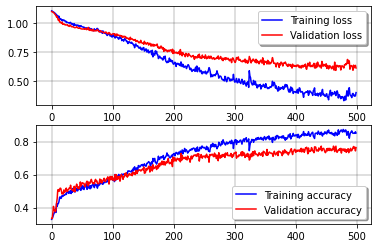

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

15/15 [==============================] - 0s 5ms/step


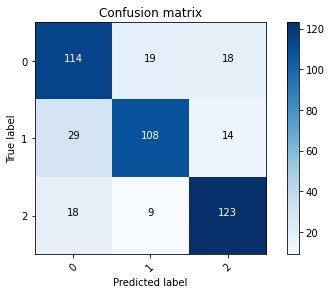

In [64]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [65]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

15/15 [==============================] - 0s 3ms/step
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


真實y值

In [66]:
print(yval[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


# 分類報告

In [67]:
def 勝率(yval,y_pred):
  t = []
  for i,j in zip(yval,y_pred):
    t.append(np.allclose(i,j))
  return np.mean(t)
勝率(yval,y_pred)

0.7632743362831859

In [68]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.71      0.75      0.73       151
         BUY       0.79      0.72      0.75       151
        SELL       0.79      0.82      0.81       150

   micro avg       0.76      0.76      0.76       452
   macro avg       0.77      0.76      0.76       452
weighted avg       0.77      0.76      0.76       452
 samples avg       0.76      0.76      0.76       452



# plot error

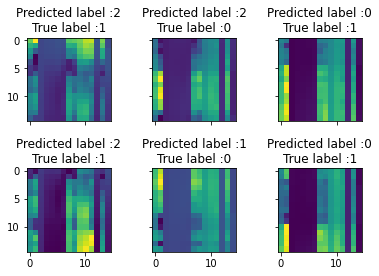

In [69]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

# 訓練集推論

71/71 [==============================] - 0s 2ms/step
[*********************100%***********************]  1 of 1 completed


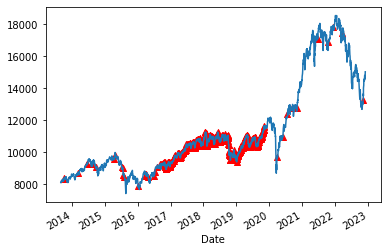

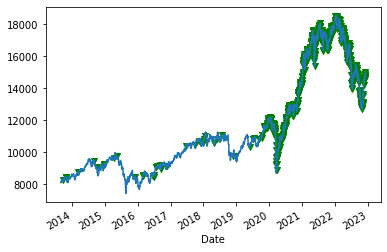

In [105]:
answer = model.predict(X_train)
answer = [ np.argmax(i) for i in answer]
C = yf.download(y_symbols, start=startdate, end=enddate)[['Close']]
C = C.loc[df[-len(answer):].index,:]
C['SIGNAL'] = answer 
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.show()
C['Close'].plot()
plt.scatter(list(sell.index),list(sell.values),color='green',marker="v")
plt.show()

## 測試集推論

2/2 [==============================] - 0s 8ms/step
[*********************100%***********************]  1 of 1 completed


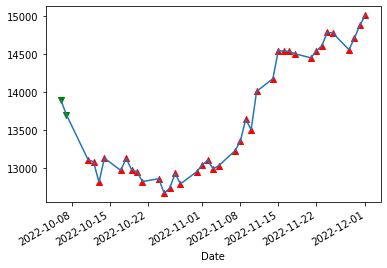

In [107]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
C = yf.download(y_symbols, start=startdate, end=enddate)[['Close']]
C = C.loc[df[-len(answer):].index,:]
C['SIGNAL'] = answer 
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='green',marker="v")
plt.show()

In [108]:
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True)
C['HOLD%'] = model.predict(X_test)[:,0]
C['BUY%'] = model.predict(X_test)[:,1]
C['SELL%'] = model.predict(X_test)[:,2]
display(C.drop(['SIGNAL'],axis=1).head(5))
display(C.drop(['SIGNAL'],axis=1).tail(5))

2/2 [==============================] - 0s 5ms/step


,Close,HOLD%,BUY%,SELL%
Date,,,,
2022-10-06,13892.0498,0.0001,0.1191,0.8808
2022-10-07,13702.2803,0.0000,0.3446,0.6554
2022-10-11,13106.0303,0.0001,0.9049,0.0951
2022-10-12,13081.2402,0.0000,0.9441,0.0559
2022-10-13,12810.7305,0.0000,0.9997,0.0003


,Close,HOLD%,BUY%,SELL%
Date,,,,
2022-11-25,14778.5098,0.0000,1.0000,0.0000
2022-11-28,14556.8701,0.0000,1.0000,0.0000
2022-11-29,14709.6396,0.0000,1.0000,0.0000
2022-11-30,14879.5498,0.0000,1.0000,0.0000
2022-12-01,15012.7998,0.0000,1.0000,0.0000


# save model

In [101]:
model.save('Rikcy_net.h5')
del model

In [103]:
from keras.models import load_model
model = load_model('Rikcy_net.h5')
predict = model.predict(X_test)
predict[-5:]

2/2 [==============================] - 0s 7ms/step


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)